In [ ]:
import warnings
import logging

# Silenciar warnings de Dask sobre "large graph of size ..."
warnings.filterwarnings(
    "ignore",
    message="Sending large graph of size",
    category=UserWarning,
    module="distributed.client"
)

# Silenciar logs de tornado/bokeh por expiración de token
logging.getLogger("tornado.application").setLevel(logging.CRITICAL)
logging.getLogger("bokeh.server").setLevel(logging.CRITICAL)

print("Warnings molestos silenciados")

# Experimentos de Modelos de Detección de Anomalías

Este notebook recoge **ejemplos de ejecución de experimentos** para todos los modelos desarrollados en el proyecto.

Se sigue un mismo flujo en todos los casos:

1. **Levantamiento del cluster Dask** (CPU o GPU).
2. **Definición de métricas de validación**.
3. **Configuración del grid de hiperparámetros**.
4. **Ejecución del experimento** con `run_dataset_experiment`.

> Los resultados obtenidos (tablas y métricas) se mostrarán pero **no se discuten aquí**, ya que el análisis se realiza en la memoria del TFG.


# Uso de Clusters en Dask

En este proyecto utilizamos **Dask** para paralelizar cálculos y acelerar los experimentos.  
Dependiendo de los recursos disponibles podemos levantar:

- **Cluster en CPU (`LocalCluster`)** → adecuado para datasets pequeños y medianos.  
- **Cluster en GPU (`LocalCUDACluster`)** → recomendado para datasets grandes y modelos más pesados (ej. Autoencoders, Transformers).  

A continuación definimos funciones auxiliares para:

1. Levantar un cluster (CPU o GPU).  
2. Cerrar el cluster actual de manera segura.


In [1]:
from dask.distributed import Client, LocalCluster
from dask_cuda import LocalCUDACluster

client = None
cluster = None

def start_cluster(use_gpu=False):
    """
    Levanta un cluster Dask en CPU o GPU según el parámetro `use_gpu`.
    
    Parámetros
    ----------
    use_gpu : bool
        - False → Levanta un LocalCluster en CPU.
        - True  → Levanta un LocalCUDACluster en GPU.
    
    Retorna
    -------
    client : dask.distributed.Client
        Cliente asociado al cluster levantado.
    """
    global client, cluster
    
    if use_gpu:
        cluster = LocalCUDACluster()
        client = Client(cluster)
        print("Cluster GPU levantado con éxito")
    else:
        cluster = LocalCluster()
        client = Client(cluster)
        print("Cluster CPU levantado con éxito")
    
    print(client)
    return client


In [2]:
def stop_cluster():
    """
    Cierra el cluster y cliente de Dask si están activos.
    """
    global client, cluster
    try:
        if client is not None:
            client.close()
            print("Cliente cerrado")
        if cluster is not None:
            cluster.close()
            print("Cluster cerrado")
    except Exception as e:
        print("No había cluster activo o ya estaba cerrado:", e)
    finally:
        client, cluster = None, None


## Métricas de Validación

En todos los experimentos se utilizan las siguientes métricas:

- **Precisión, Recall, F1, ROC-AUC**
- **NAB Score**
- **Window Coverage**

Se importan una sola vez y se comparten entre todos los modelos.


In [3]:
from modelos.validation_metrics import (
    precision_metric, recall_metric, f1_metric,
    roc_auc_metric, nab_metric, window_coverage_metric
)

metrics = {
    "precision": precision_metric,
    "recall": recall_metric,
    "f1": f1_metric,
    "roc_auc": roc_auc_metric,
    "nab": nab_metric,
    "window_coverage": window_coverage_metric,
}


## 1. Experimentos sobre el modelo de Detección de Anomalías con PCA

El modelo de **Análisis de Componentes Principales (PCA)** reduce la dimensionalidad de los datos y utiliza el **error de reconstrucción** como criterio para detectar anomalías.  

En este proyecto se han implementado **dos variantes** del PCA:

- **PCA-CPU** → basado en `sklearn`, optimizado para paralelismo en CPU.  
- **PCA-GPU** → basado en `cuML`, optimizado para GPUs mediante CUDA.  

La elección de la implementación depende del tamaño del dataset:

- Para datasets **pequeños/medianos** (`BATADAL`, `SKAB`, `EbayRanSynCoders`, `MSL`, `SMAP`), se utilizará la versión **CPU**.  
- Para datasets **grandes** (`WADI`), se utilizará la versión **GPU** para aprovechar la aceleración.  

De este modo, se optimiza tanto la **velocidad de entrenamiento** como el **uso eficiente de recursos de cómputo**.


### 1.1 Ejecución de experimentos con modelo CPU

In [ ]:
from runner import run_dataset_experiment
from modelos.PCAAnomalyDetector import PCAAnomalyDetectorCPU

param_grid = {
    "n_components": None,
    "threshold": [1.0, 1.5, 2.0, 2.5, 3.0, 4.0, 5.0] 
}

datasets = ["BATADAL", "SKAB", "EbayRanSynCoders", "MSL", "SMAP"]

start_cluster(use_gpu=False)

for dataset in datasets:
    df_results, topk, df_final = run_dataset_experiment(
        dataset_name=dataset,
        model_class=PCAAnomalyDetectorCPU,
        param_grid=param_grid,
        metrics=metrics,
        params_cv={"num_windows": 5},
        device="cpu",
        mode="tscv",
        hampel_cfg={"window": 25, "sigma": 5.0},
        top_k=8,
        sort_metric="nab",
        plot_mode="best"
    )

stop_cluster()

### 1.2 Ejecución de experimentos con modelo GPU

In [ ]:
from runner import run_dataset_experiment
from modelos.PCAAnomalyDetector import PCAAnomalyDetectorGPU

# Grid de hiperparámetros
param_grid = {
    "n_components": None,   # se calcula dinámicamente
    "threshold": [1.0, 1.5, 2.0, 2.5, 3.0, 4.0, 5.0]
}

# Dataset grande -> GPU
datasets = ["WADI"]

# Levantamos cluster en GPU
start_cluster(use_gpu=True)

for dataset in datasets:
    df_results, topk, df_final = run_dataset_experiment(
        dataset_name=dataset,
        model_class=PCAAnomalyDetectorGPU,
        param_grid=param_grid,
        metrics=metrics,
        params_cv={"num_windows": 3},   # menos splits por tamaño del dataset
        device="gpu",
        mode="tscv",
        hampel_cfg={"window": 50, "sigma": 5.0},
        top_k=8,
        sort_metric="nab",
        plot_mode="best"
    )

# Cerramos cluster
stop_cluster()

## 2. Experimentos sobre el modelo de Detección de Anomalías con Isolation Forest

El algoritmo **Isolation Forest (IForest)** es un método basado en árboles de decisión que detecta anomalías 
a partir de la idea de que los puntos anómalos son más fáciles de aislar que los normales.  

En este enfoque, se construyen múltiples árboles aleatorios (*isolation trees*) donde cada división separa el 
espacio de características. Los puntos que requieren **pocas divisiones para quedar aislados** son más 
probablemente anomalías, mientras que los puntos normales necesitan más divisiones.

Este modelo presenta varias ventajas clave:

- Es **no supervisado** y no requiere etiquetas en el entrenamiento.
- Escala bien a grandes volúmenes de datos gracias a su **paralelización**.
- Permite controlar el nivel esperado de anomalías mediante el parámetro `contamination`.

En este proyecto se han implementado **dos variantes**:

- **Isolation Forest CPU** → implementación basada en `sklearn`, adecuada para datasets pequeños y medianos.  
- **Isolation Forest GPU** → implementación optimizada con `cuML`, recomendada para datasets grandes.  

De esta manera, se busca equilibrar el **rendimiento computacional** con la **calidad en la detección de anomalías**, 
dependiendo de las características del dataset en uso.


### 2.1 Ejecución de experimentos con modelo CPU

Cluster CPU levantado con éxito
<Client: 'tcp://127.0.0.1:46351' processes=4 threads=16, memory=49.02 GiB>
🏁 Ejecutando experimento en dataset: BATADAL
[✓] DATA cargado desde /home/pablo/TFG/MDF-ANOMALY-DETECTION/modelos/data/BATADAL/data.parquet (12938 filas)
   - Train: 8761 filas
   - Val:   2506 filas
   - Test:  1671 filas
Usando CPU (pandas + numpy) para este experimento.


Evaluación en test: 100%|██████████| 8/8 [00:01<00:00,  4.93it/s]

Top 8 configuraciones (ordenadas por nab en validación):


,precision,recall,f1,roc_auc,nab,window_coverage,n_trees,sample_size,contamination,split_selection_random
8,0.072,0.047,0.055,0.540,0.374,0.047,100,512,0.001,False
0,0.076,0.063,0.066,0.629,0.278,0.063,100,256,0.001,False
16,0.084,0.071,0.077,0.582,0.243,0.071,200,256,0.001,False
24,0.080,0.074,0.076,0.586,0.195,0.074,200,512,0.001,False
9,0.072,0.082,0.071,0.536,0.182,0.082,100,512,0.001,True
1,0.049,0.096,0.064,0.533,0.111,0.096,100,256,0.001,True
10,0.064,0.123,0.084,0.579,0.108,0.123,100,512,0.005,False
2,0.074,0.133,0.095,0.564,0.107,0.133,100,256,0.005,False


Resultados finales en TEST (top-k configs):


,precision,recall,f1,roc_auc,nab,window_coverage,n_trees,sample_size,contamination,split_selection_random
0,0.500,0.026,0.049,0.657,0.597,0.018,100,512,0.001,False
1,0.250,0.009,0.017,0.630,0.270,0.009,100,256,0.001,False
2,0.667,0.017,0.033,0.697,0.537,0.014,200,256,0.001,False
3,0.000,0.000,0.000,0.707,-0.018,0.000,200,512,0.001,False
4,0.833,0.043,0.081,0.795,0.596,0.027,100,512,0.001,True
5,0.000,0.000,0.000,0.713,-0.037,0.000,100,256,0.001,True
6,0.200,0.017,0.031,0.673,0.103,0.009,100,512,0.005,False
7,0.385,0.043,0.077,0.662,0.480,0.036,100,256,0.005,False


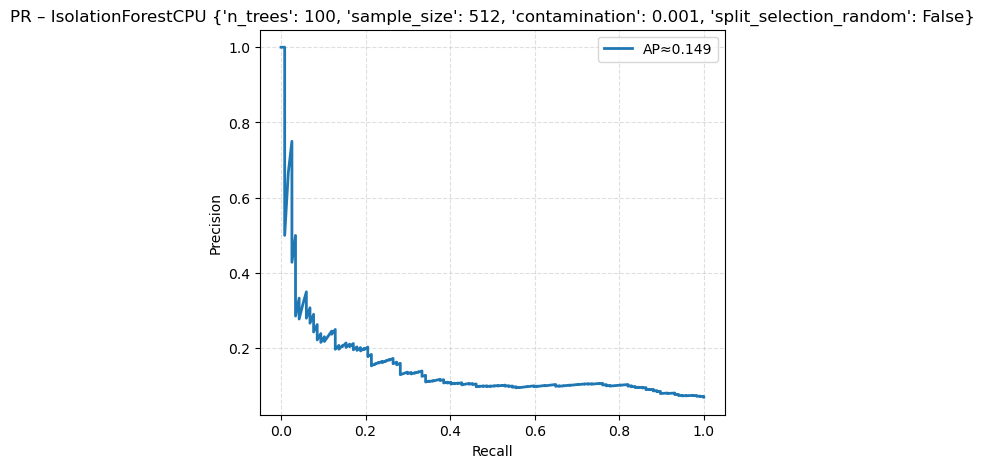

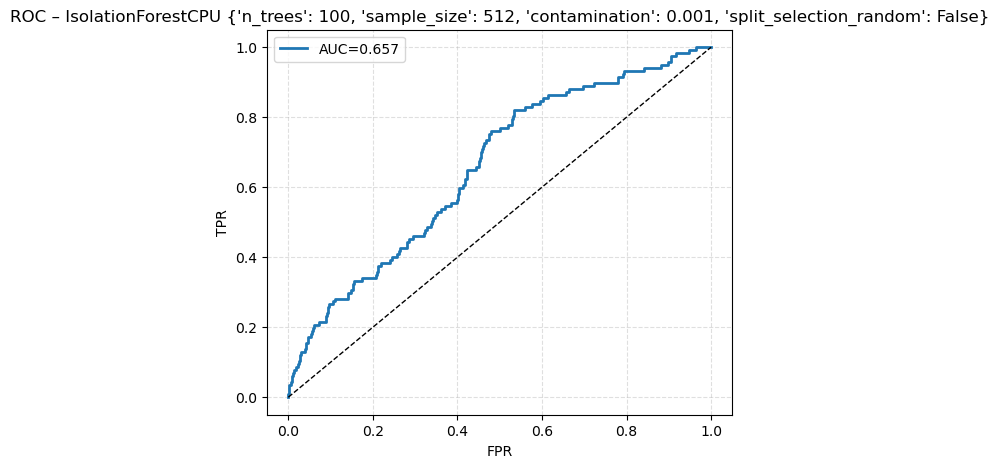

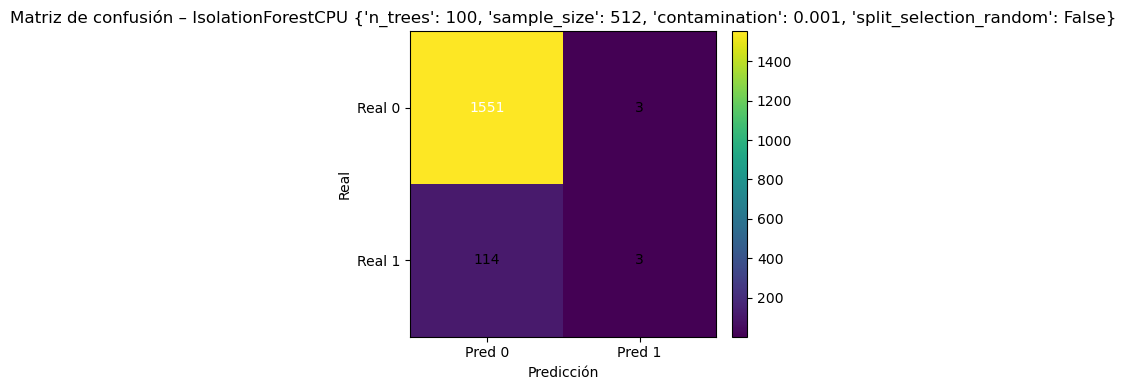

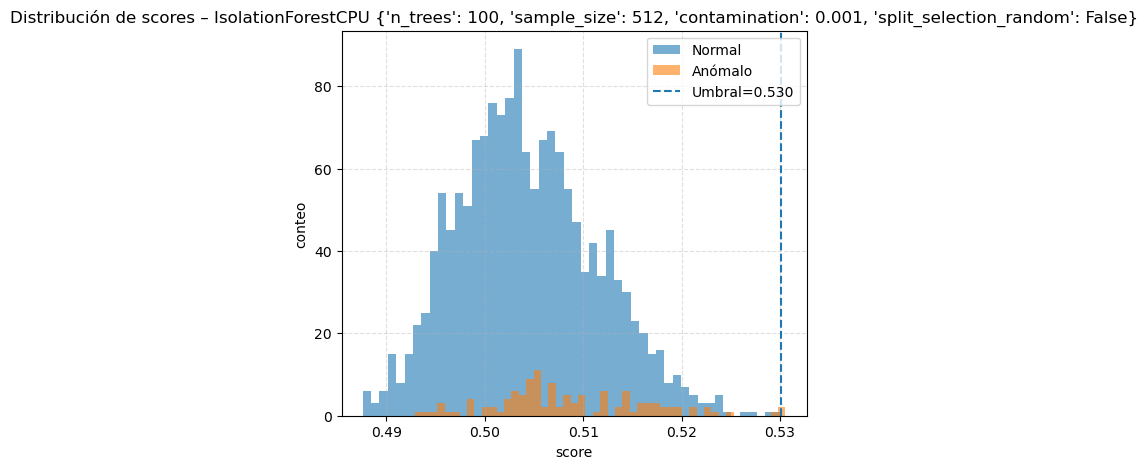

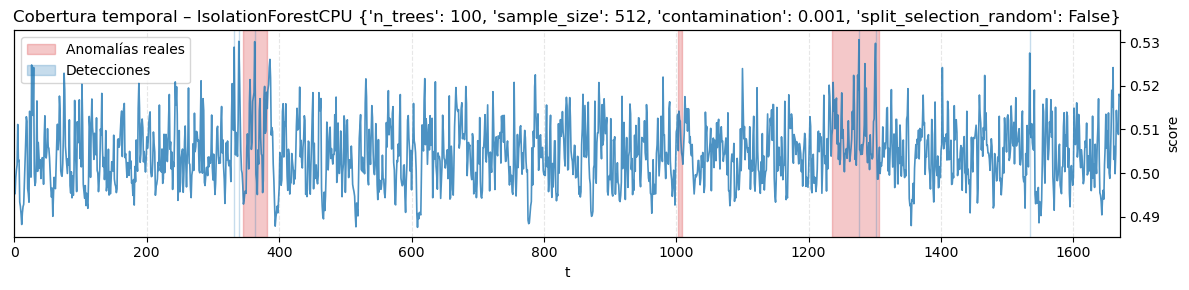

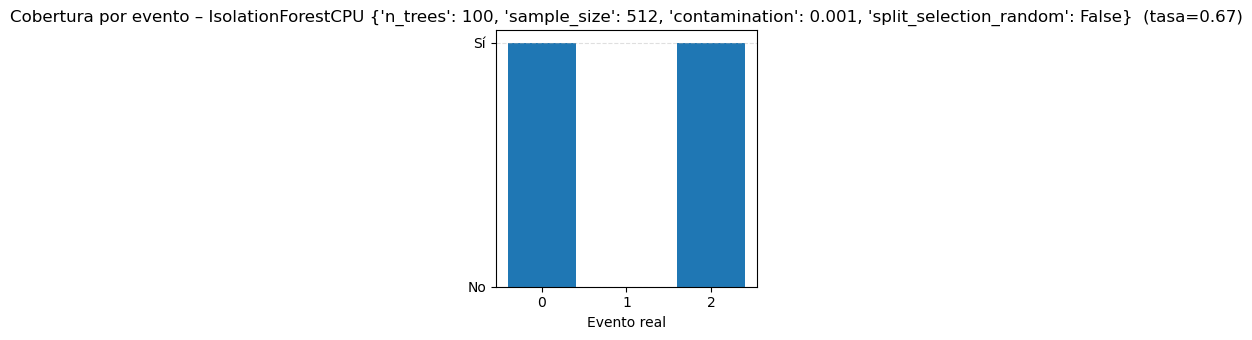

🏁 Ejecutando experimento en dataset: SKAB
[✓] DATA cargado desde /home/pablo/TFG/MDF-ANOMALY-DETECTION/modelos/data/SKAB/data.parquet (27563 filas)
   - Train: 9401 filas
   - Val:   10897 filas
   - Test:  7265 filas
Usando CPU (pandas + numpy) para este experimento.


Evaluación en test: 100%|██████████| 8/8 [00:12<00:00,  1.56s/it]

Top 8 configuraciones (ordenadas por nab en validación):


,precision,recall,f1,roc_auc,nab,window_coverage,n_trees,sample_size,contamination,split_selection_random
16,0.714,0.093,0.150,0.675,0.312,0.089,200,256,0.001,False
24,0.675,0.086,0.136,0.679,0.296,0.082,200,512,0.001,False
0,0.685,0.113,0.184,0.682,0.233,0.107,100,256,0.001,False
8,0.689,0.094,0.154,0.676,0.230,0.089,100,512,0.001,False
25,0.526,0.248,0.190,0.657,0.198,0.246,200,512,0.001,True
9,0.570,0.245,0.183,0.659,0.183,0.243,100,512,0.001,True
17,0.503,0.235,0.166,0.645,0.029,0.234,200,256,0.001,True
1,0.507,0.247,0.182,0.661,0.002,0.245,100,256,0.001,True


Resultados finales en TEST (top-k configs):


,precision,recall,f1,roc_auc,nab,window_coverage,n_trees,sample_size,contamination,split_selection_random
0,0.929,0.070,0.130,0.791,0.913,0.066,200,256,0.001,False
1,0.867,0.102,0.182,0.822,0.742,0.097,200,512,0.001,False
2,0.868,0.052,0.099,0.761,0.848,0.050,100,256,0.001,False
3,0.899,0.064,0.120,0.836,0.874,0.062,100,512,0.001,False
4,0.857,0.005,0.009,0.809,0.675,0.005,200,512,0.001,True
5,1.000,0.007,0.014,0.854,0.831,0.007,100,512,0.001,True
6,0.833,0.002,0.004,0.843,0.539,0.002,200,256,0.001,True
7,1.000,0.007,0.014,0.842,0.826,0.008,100,256,0.001,True


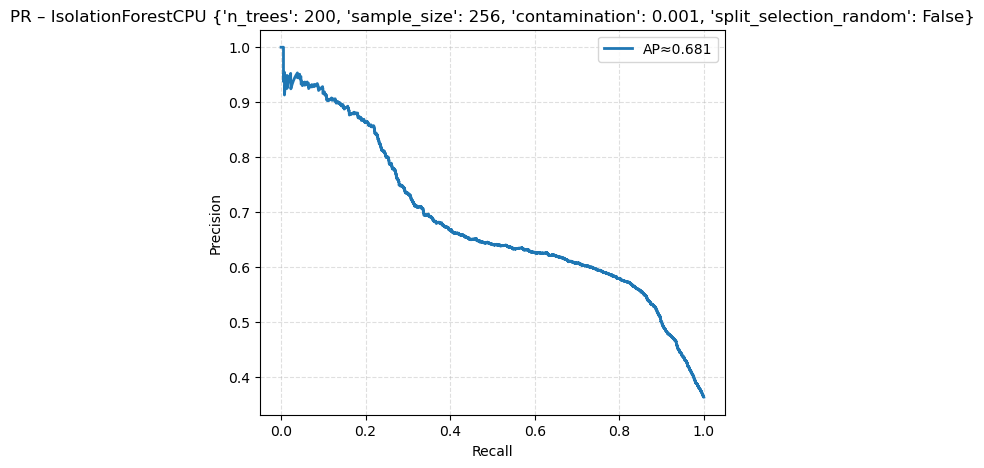

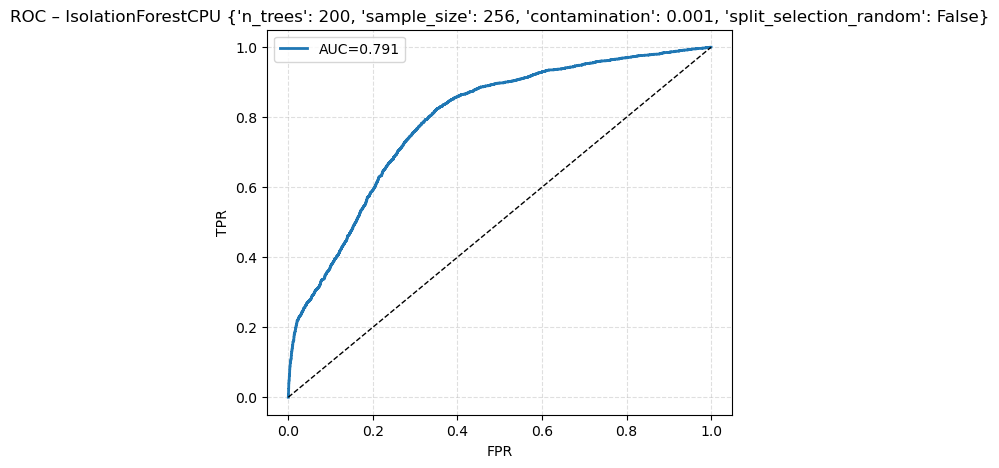

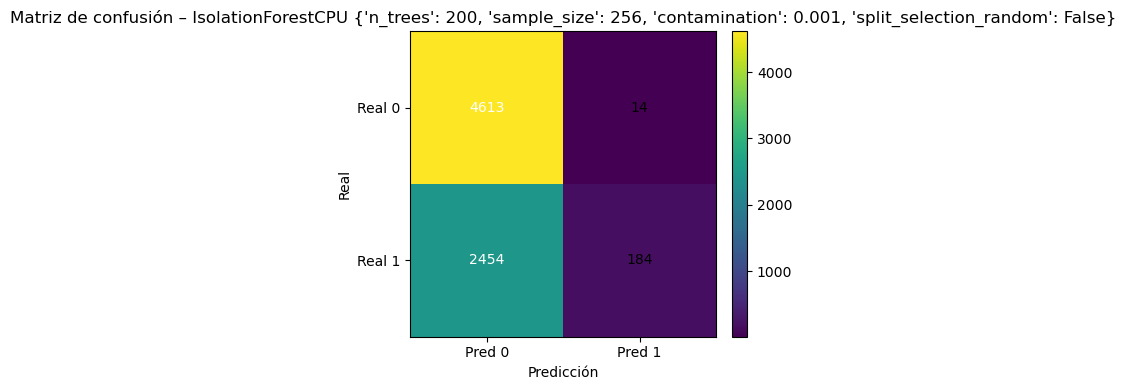

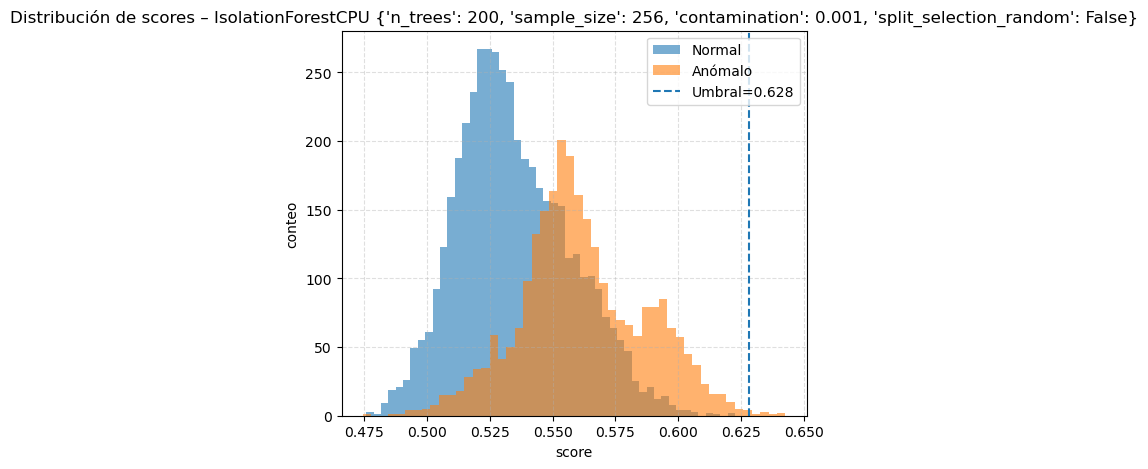

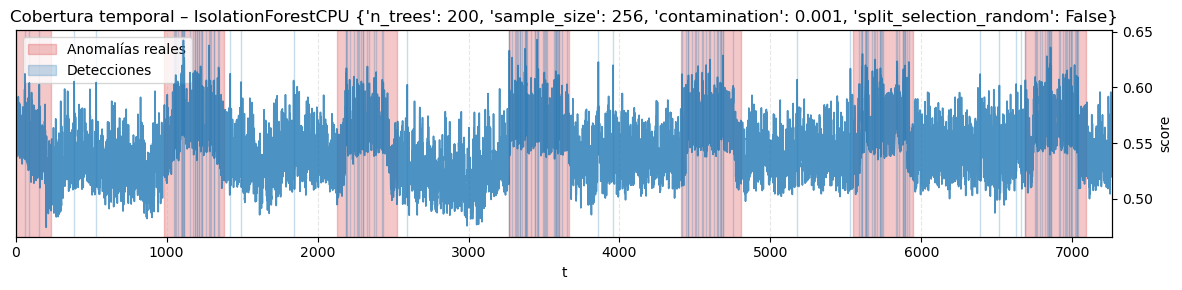

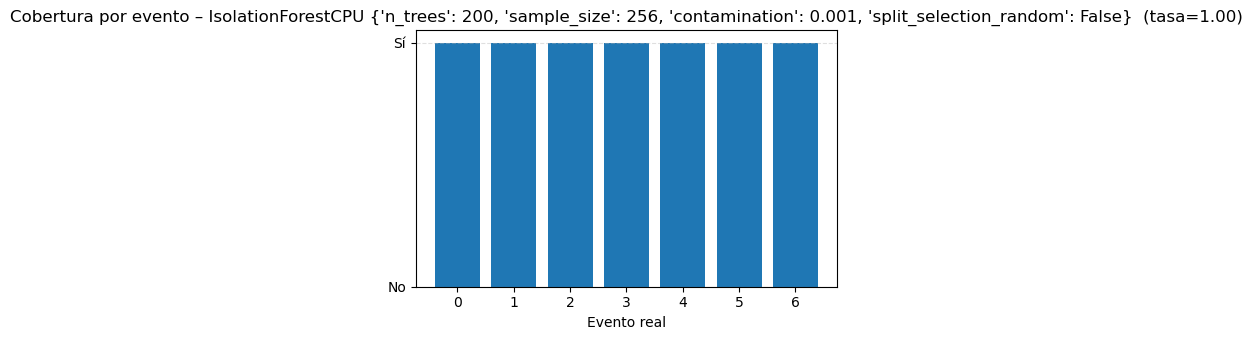

🏁 Ejecutando experimento en dataset: EbayRanSynCoders
[✓] DATA cargado desde /home/pablo/TFG/MDF-ANOMALY-DETECTION/modelos/data/EbayRanSynCoders/data.parquet (220322 filas)
   - Train: 132481 filas
   - Val:   52704 filas
   - Test:  35137 filas
Usando CPU (pandas + numpy) para este experimento.


/home/pablo/miniforge3/envs/anomaly-detection/lib/python3.11/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 36.74 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
Evaluación en test: 100%|██████████| 8/8 [01:11<00:00,  8.95s/it]

Top 8 configuraciones (ordenadas por nab en validación):


,precision,recall,f1,roc_auc,nab,window_coverage,n_trees,sample_size,contamination,split_selection_random
31,0.765,0.110,0.161,0.738,0.202,0.123,200,512,0.050,True
20,0.893,0.060,0.097,0.710,0.184,0.019,200,256,0.010,False
23,0.742,0.089,0.128,0.731,0.176,0.099,200,256,0.050,True
28,0.829,0.059,0.094,0.725,0.172,0.019,200,512,0.010,False
15,0.780,0.104,0.141,0.738,0.161,0.120,100,512,0.050,True
18,0.800,0.056,0.088,0.737,0.137,0.015,200,256,0.005,False
26,0.600,0.056,0.088,0.742,0.122,0.018,200,512,0.005,False
4,0.594,0.059,0.094,0.714,0.120,0.019,100,256,0.010,False


Resultados finales en TEST (top-k configs):


,precision,recall,f1,roc_auc,nab,window_coverage,n_trees,sample_size,contamination,split_selection_random
0,0.667,0.174,0.276,0.738,-1.000,0.199,200,512,0.050,True
1,0.179,0.003,0.006,0.641,-0.174,0.001,200,256,0.010,False
2,0.627,0.145,0.236,0.734,-0.829,0.133,200,256,0.050,True
3,0.196,0.012,0.022,0.631,-0.715,0.007,200,512,0.010,False
4,0.683,0.127,0.214,0.746,-0.649,0.164,100,512,0.050,True
5,0.389,0.001,0.001,0.632,0.034,0.000,200,256,0.005,False
6,0.316,0.003,0.007,0.675,-0.033,0.001,200,512,0.005,False
7,0.099,0.013,0.023,0.531,-1.000,0.033,100,256,0.010,False


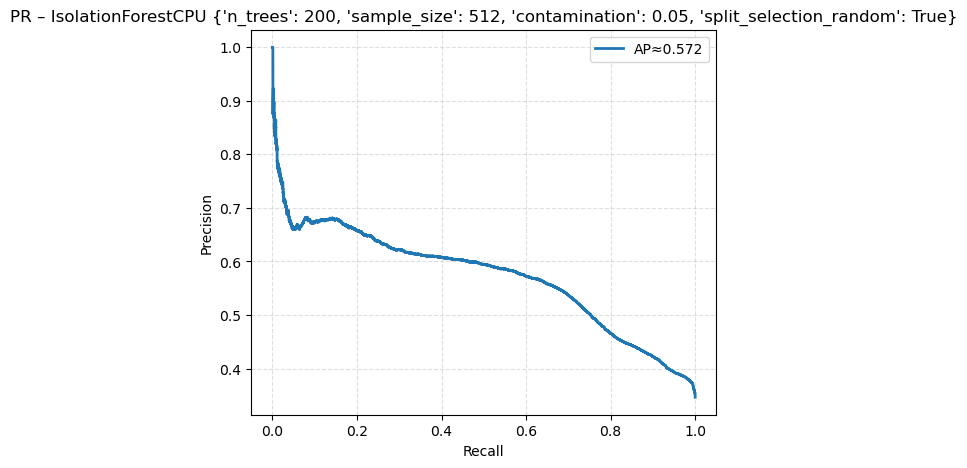

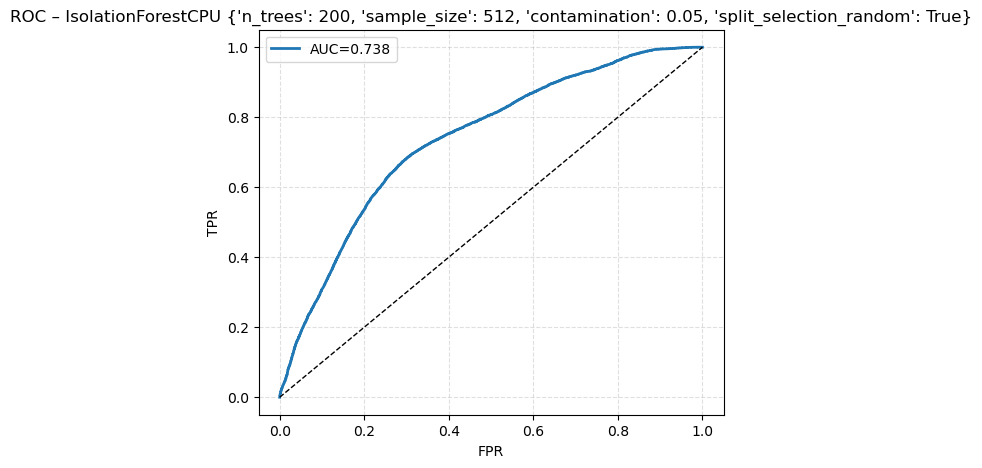

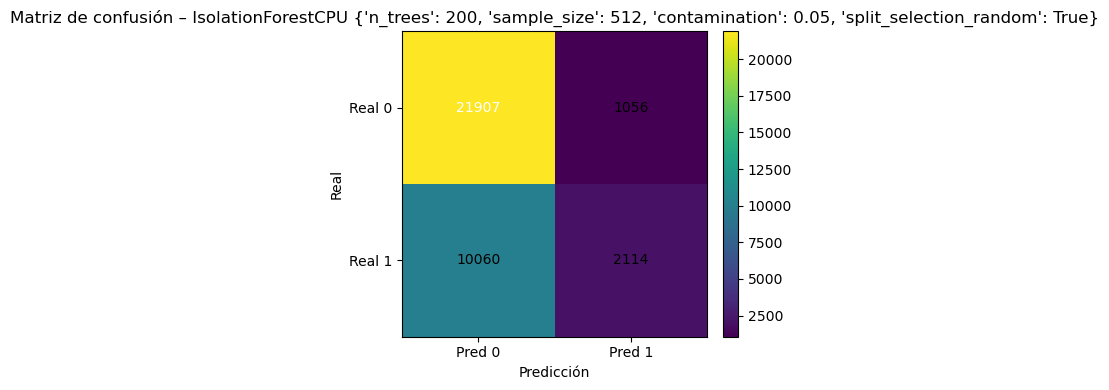

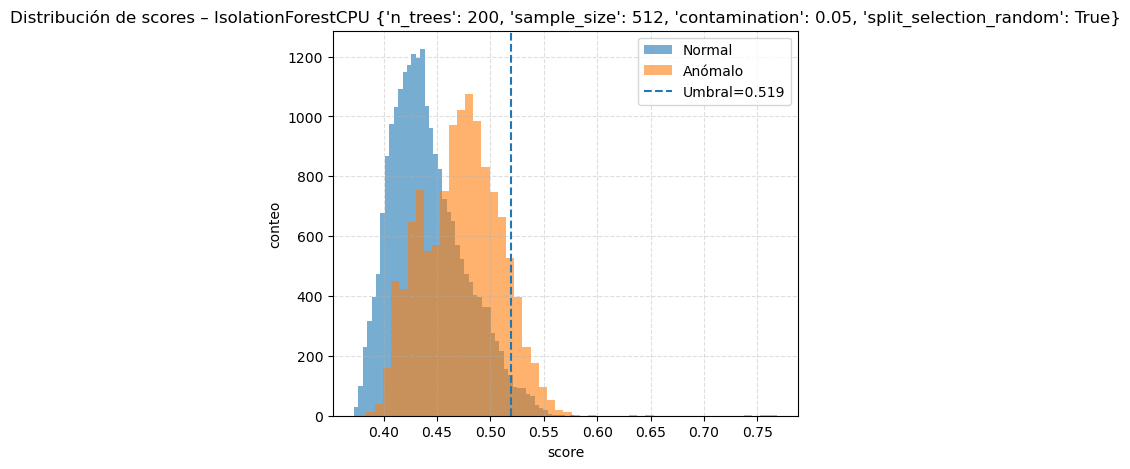

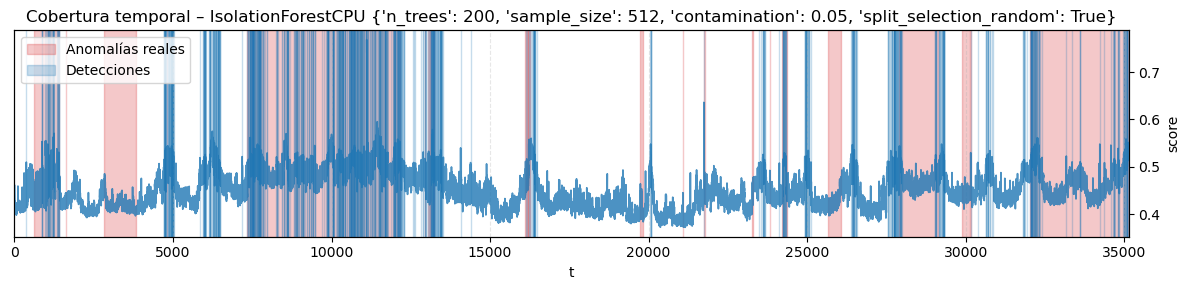

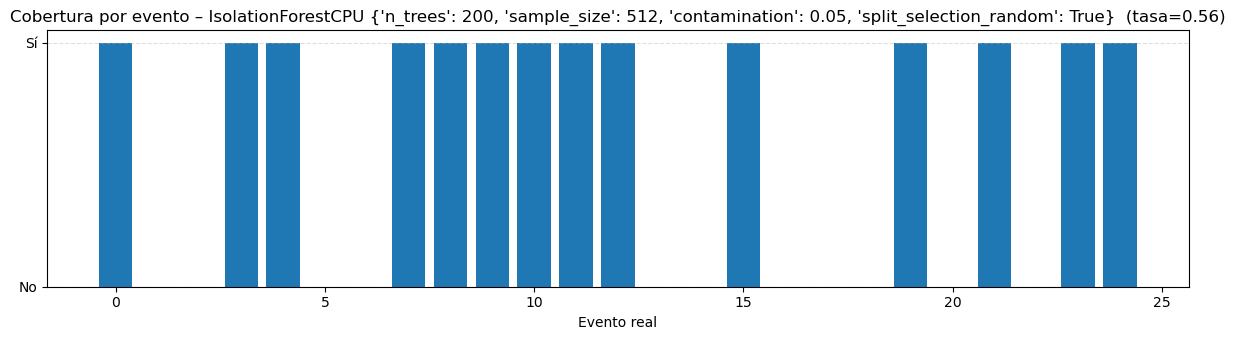

🏁 Ejecutando experimento en dataset: MSL
[✓] DATA cargado desde /home/pablo/TFG/MDF-ANOMALY-DETECTION/modelos/data/MSL/data.parquet (132046 filas)
   - Train: 58317 filas
   - Val:   44237 filas
   - Test:  29492 filas
Usando CPU (pandas + numpy) para este experimento.


/home/pablo/miniforge3/envs/anomaly-detection/lib/python3.11/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 22.31 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
Evaluación en test: 100%|██████████| 8/8 [00:04<00:00,  1.83it/s]

Top 8 configuraciones (ordenadas por nab en validación):


,precision,recall,f1,roc_auc,nab,window_coverage,n_trees,sample_size,contamination,split_selection_random
24,0.158,0.180,0.133,0.566,-0.600,0.203,200,512,0.001,False
17,0.122,0.104,0.112,0.532,-0.603,0.129,200,256,0.001,True
16,0.194,0.258,0.109,0.541,-0.643,0.280,200,256,0.001,False
26,0.175,0.057,0.079,0.575,-0.700,0.091,200,512,0.005,False
18,0.155,0.175,0.121,0.557,-0.700,0.139,200,256,0.005,False
10,0.302,0.461,0.270,0.551,-0.732,0.395,100,512,0.005,False
2,0.247,0.325,0.187,0.516,-0.732,0.319,100,256,0.005,False
20,0.227,0.198,0.157,0.568,-0.766,0.227,200,256,0.010,False


Resultados finales en TEST (top-k configs):


,precision,recall,f1,roc_auc,nab,window_coverage,n_trees,sample_size,contamination,split_selection_random
0,0.056,0.002,0.005,0.417,0.084,0.002,200,512,0.001,False
1,0.000,0.000,0.000,0.480,-0.454,0.000,200,256,0.001,True
2,0.000,0.000,0.000,0.430,0.000,0.000,200,256,0.001,False
3,0.040,0.011,0.017,0.500,-0.573,0.010,200,512,0.005,False
4,0.076,0.010,0.017,0.557,-0.087,0.009,200,256,0.005,False
5,0.000,0.000,0.000,0.494,0.000,0.000,100,512,0.005,False
6,0.043,1.000,0.082,0.500,-1.000,1.000,100,256,0.005,False
7,0.000,0.000,0.000,0.509,0.000,0.000,200,256,0.010,False


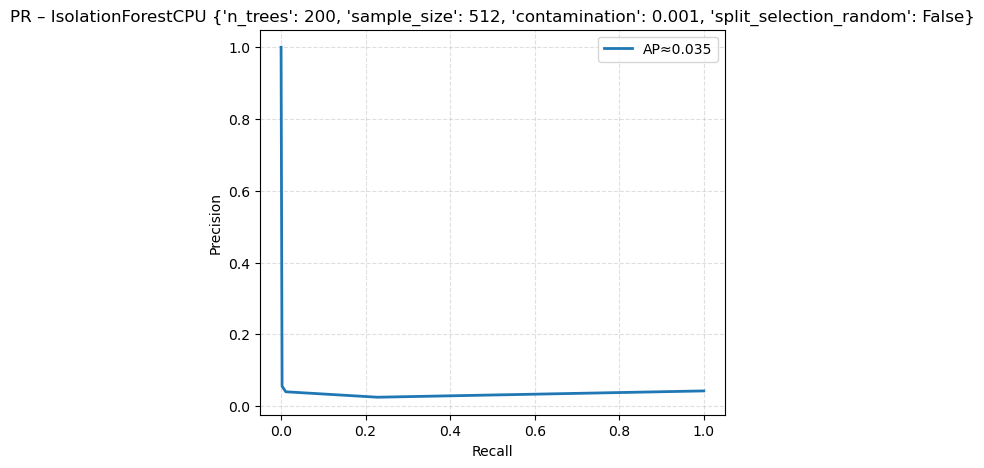

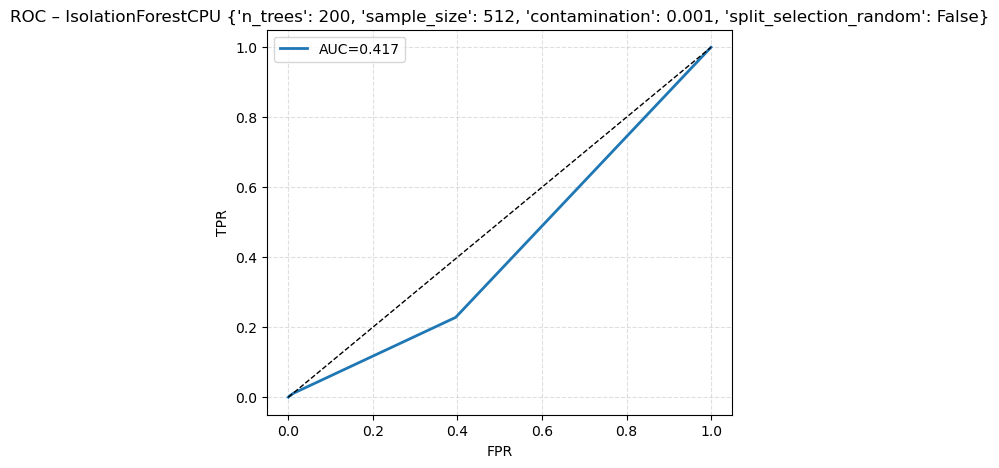

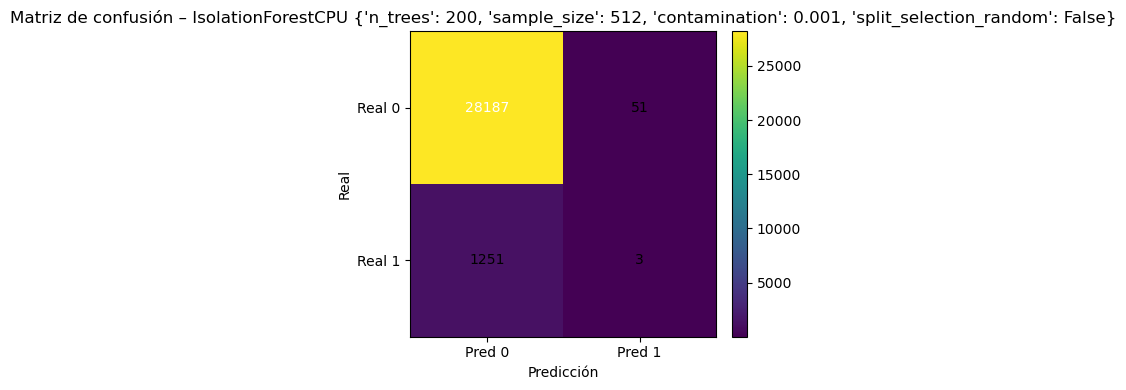

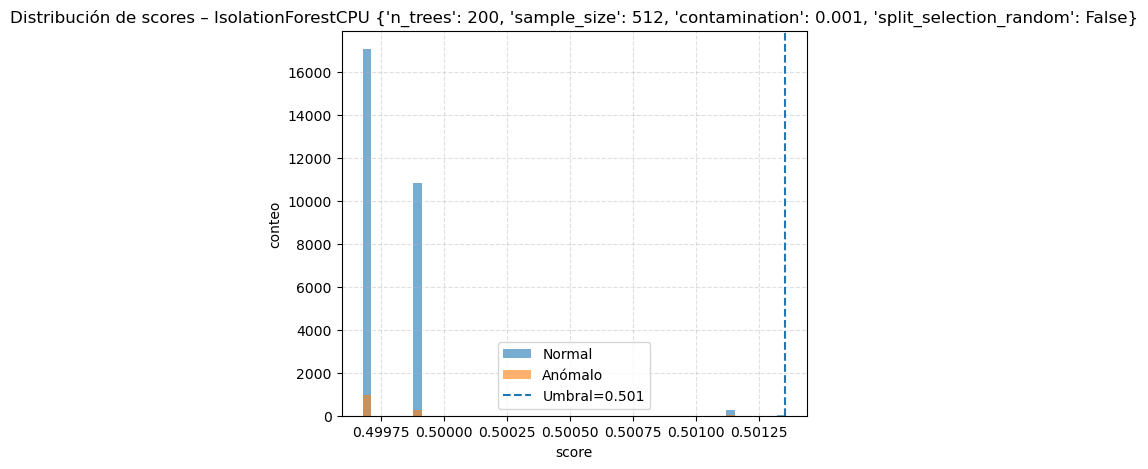

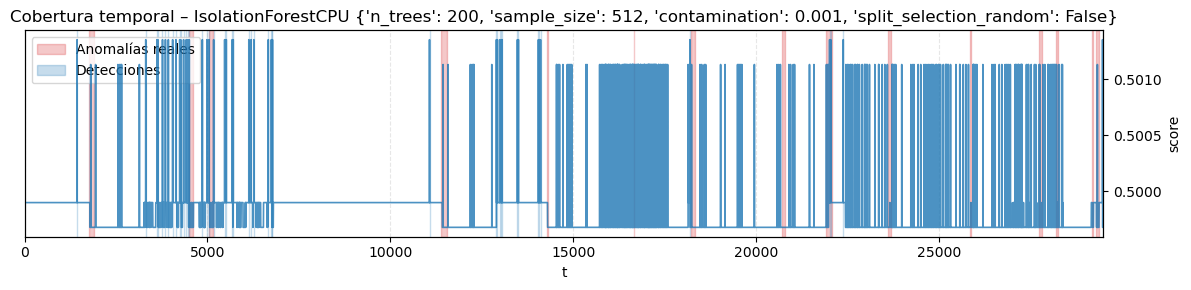

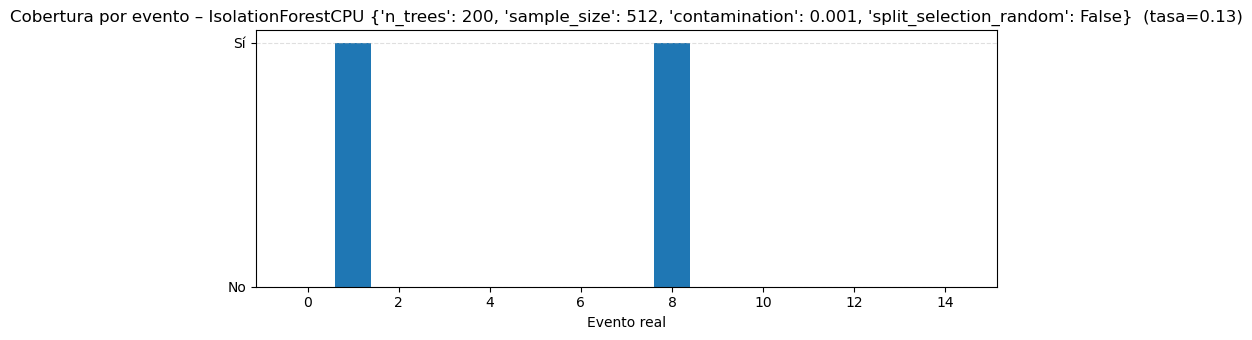

🏁 Ejecutando experimento en dataset: SMAP
[✓] DATA cargado desde /home/pablo/TFG/MDF-ANOMALY-DETECTION/modelos/data/SMAP/data.parquet (562800 filas)
   - Train: 135183 filas
   - Val:   256570 filas
   - Test:  171047 filas
Usando CPU (pandas + numpy) para este experimento.


/home/pablo/miniforge3/envs/anomaly-detection/lib/python3.11/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 40.36 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
Evaluación en test: 100%|██████████| 8/8 [00:23<00:00,  2.94s/it]

Top 8 configuraciones (ordenadas por nab en validación):


,precision,recall,f1,roc_auc,nab,window_coverage,n_trees,sample_size,contamination,split_selection_random
0,0.208,0.199,0.176,0.528,-0.689,0.173,100,256,0.001,False
5,0.099,0.059,0.069,0.539,-0.746,0.101,100,256,0.010,True
20,0.072,0.074,0.069,0.431,-0.800,0.129,200,256,0.010,False
16,0.189,0.186,0.168,0.524,-0.800,0.199,200,256,0.001,False
4,0.093,0.293,0.126,0.425,-1.000,0.375,100,256,0.010,False
3,0.096,0.059,0.071,0.472,-1.000,0.097,100,256,0.005,True
30,0.096,0.240,0.121,0.419,-1.000,0.370,200,512,0.050,False
29,0.087,0.061,0.069,0.412,-1.000,0.105,200,512,0.010,True


Resultados finales en TEST (top-k configs):


,precision,recall,f1,roc_auc,nab,window_coverage,n_trees,sample_size,contamination,split_selection_random
0,0.006,0.001,0.002,0.377,-1.000,0.008,100,256,0.001,False
1,0.043,0.004,0.007,0.398,-1.000,0.010,100,256,0.010,True
2,0.013,0.030,0.018,0.421,-1.000,0.171,200,256,0.010,False
3,0.000,0.000,0.000,0.332,-0.127,0.000,200,256,0.001,False
4,0.006,0.001,0.002,0.372,-1.000,0.008,100,256,0.010,False
5,0.010,0.000,0.000,0.422,-0.387,0.000,100,256,0.005,True
6,0.027,0.011,0.016,0.370,-1.000,0.033,200,512,0.050,False
7,0.037,0.003,0.005,0.388,-1.000,0.009,200,512,0.010,True


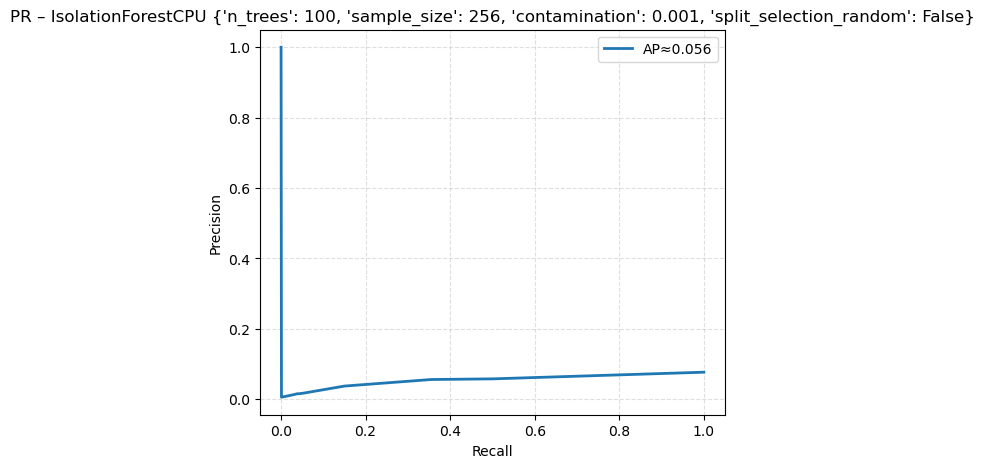

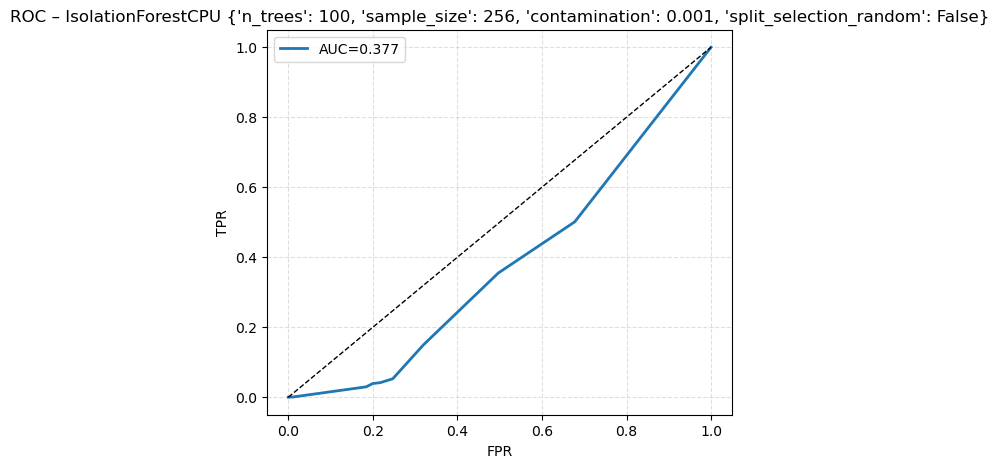

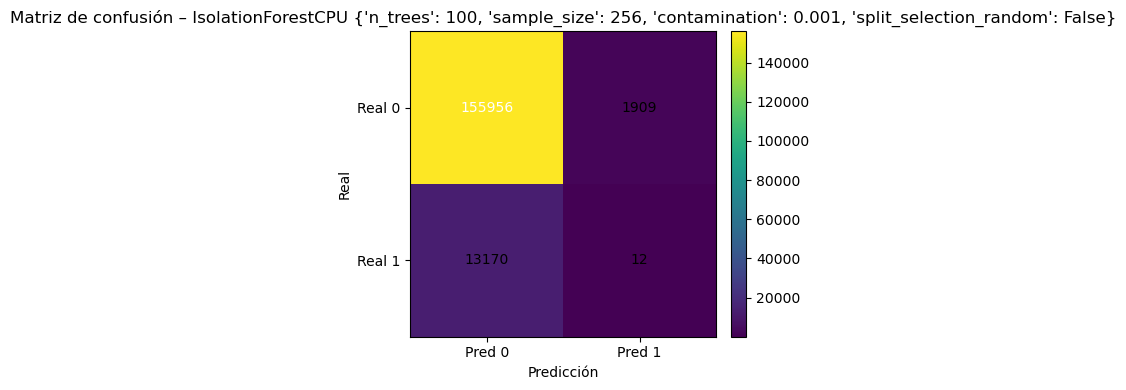

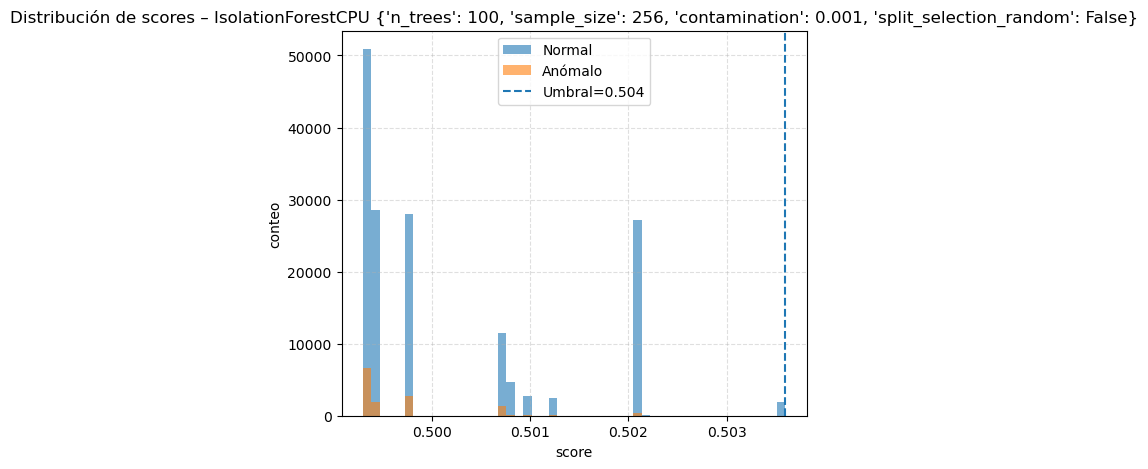

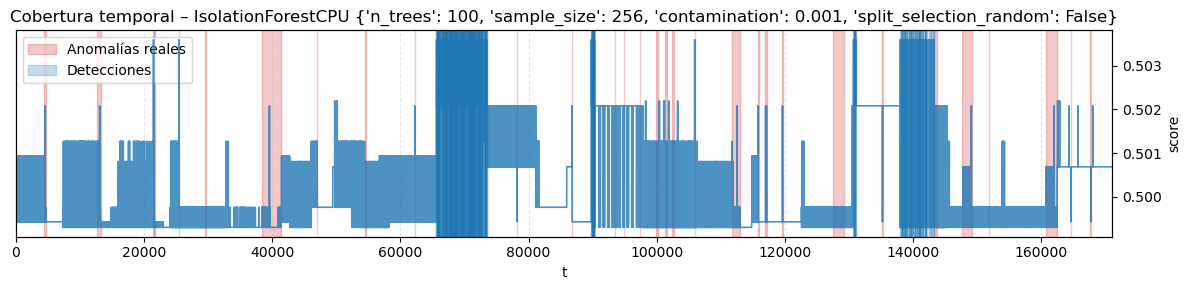

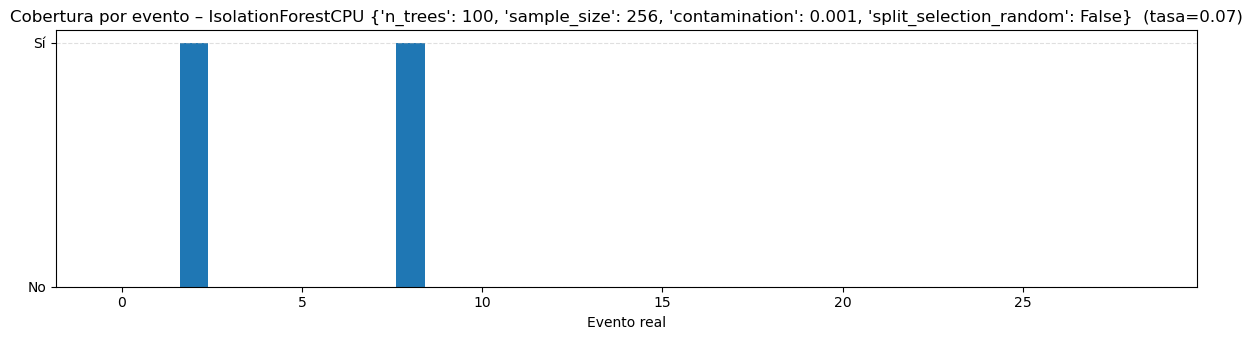

Cliente cerrado
Cluster cerrado


In [4]:
from runner import run_dataset_experiment
from modelos.IsolationForest import IsolationForestCPU

param_grid = {
    "n_trees": [100, 200],         
    "sample_size": [256, 512],            
    "contamination": [0.001, 0.005, 0.01, 0.05], 
    "split_selection_random": [False, True],
}


datasets = ["BATADAL", "SKAB", "EbayRanSynCoders", "MSL", "SMAP"]

start_cluster(use_gpu=False)

for dataset in datasets:
    df_results, topk, df_final = run_dataset_experiment(
        dataset_name=dataset,
        model_class=IsolationForestCPU,
        param_grid=param_grid,
        metrics=metrics,
        params_cv={"num_windows": 5},
        device="cpu",
        mode="tscv",
        hampel_cfg={"window": 25, "sigma": 5.0},
        top_k=8,
        sort_metric="nab",
        plot_mode="best"
    )

stop_cluster()

### 2.2 Ejecución de experimentos con modelo GPU

In [ ]:
from runner import run_dataset_experiment
from modelos.IsolationForest import IsolationForest

param_grid = {
    "n_trees": [100, 200],         
    "sample_size": [256, 512],            
    "contamination": [0.001, 0.005, 0.01, 0.05], 
    "split_selection_random": [False, True],
}

datasets = ["WADI"]

start_cluster(use_gpu=True)

for dataset in datasets:
    df_results, topk, df_final = run_dataset_experiment(
        dataset_name=dataset,
        model_class=IsolationForest,
        param_grid=param_grid,
        metrics=metrics,
        params_cv={"num_windows": 3},
        device="gpu",
        mode="tscv",
        hampel_cfg={"window": 25, "sigma": 5.0},
        top_k=8,
        sort_metric="nab",
        plot_mode="best"
    )

stop_cluster()

## 3. Experimentos sobre el modelo de Detección de Anomalías con One-Class SVM

El modelo **One-Class Support Vector Machine (One-Class SVM)** aprende una frontera en el espacio 
de características que encierra la mayoría de los datos considerados normales. 
Los puntos que quedan fuera de esta frontera se interpretan como anomalías.  

En este proyecto se utiliza una única implementación basada en **CPU** con `sklearn`, 
aprovechando el paralelismo disponible.  

Dado que el algoritmo es computacionalmente costoso en datasets grandes, 
en casos como **WADI** será necesario **reducir el número de tareas o workers** en el cluster 
para no superar la memoria disponible.  

Los principales hiperparámetros a explorar son:

- `nu`: fracción de anomalías esperadas en los datos.  
- `kernel`: tipo de función núcleo (en la práctica, suele funcionar mejor el RBF).  
- `gamma`: define la influencia de cada muestra, con valores pequeños produciendo fronteras más suaves.  


### Ejecución de experimento para datasets pequeños/medianos

Cluster CPU levantado con éxito
<Client: 'tcp://127.0.0.1:33551' processes=4 threads=16, memory=49.02 GiB>
🏁 Ejecutando experimento en dataset: BATADAL
[✓] DATA cargado desde /home/pablo/TFG/MDF-ANOMALY-DETECTION/modelos/data/BATADAL/data.parquet (12938 filas)
   - Train: 8761 filas
   - Val:   2506 filas
   - Test:  1671 filas
Usando CPU (pandas + numpy) para este experimento.


2025-10-03 13:04:37,954 - tornado.application - ERROR - Uncaught exception GET /status/ws (127.0.0.1)
HTTPServerRequest(protocol='http', host='localhost:8787', method='GET', uri='/status/ws', version='HTTP/1.1', remote_ip='127.0.0.1')
Traceback (most recent call last):
  File "/home/pablo/miniforge3/envs/anomaly-detection/lib/python3.11/site-packages/tornado/websocket.py", line 965, in _accept_connection
    open_result = handler.open(*handler.open_args, **handler.open_kwargs)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pablo/miniforge3/envs/anomaly-detection/lib/python3.11/site-packages/tornado/web.py", line 3375, in wrapper
    return method(self, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pablo/miniforge3/envs/anomaly-detection/lib/python3.11/site-packages/bokeh/server/views/ws.py", line 149, in open
    raise ProtocolError("Token is expired. Configure the app with a larger value for --session-token-expiration 

Top 8 configuraciones (ordenadas por nab en validación):


,precision,recall,f1,roc_auc,nab,window_coverage,nu,kernel,gamma
2,0.042,0.291,0.073,0.486,-0.238,0.297,0.001,rbf,0.01
1,0.042,0.291,0.073,0.499,-0.239,0.297,0.001,rbf,auto
7,0.042,0.291,0.073,0.485,-0.239,0.297,0.005,rbf,0.01
6,0.042,0.291,0.073,0.500,-0.239,0.297,0.005,rbf,auto
11,0.042,0.291,0.073,0.499,-0.241,0.297,0.010,rbf,auto
12,0.042,0.291,0.073,0.487,-0.242,0.297,0.010,rbf,0.01
5,0.041,0.291,0.073,0.473,-0.243,0.297,0.005,rbf,scale
0,0.041,0.291,0.073,0.473,-0.243,0.297,0.001,rbf,scale


Resultados finales en TEST (top-k configs):


,precision,recall,f1,roc_auc,nab,window_coverage,nu,kernel,gamma
0,0.631,0.556,0.591,0.750,0.643,0.362,0.001,rbf,0.01
1,0.563,0.573,0.568,0.790,0.386,0.414,0.001,rbf,auto
2,0.617,0.564,0.589,0.776,0.588,0.367,0.005,rbf,0.01
3,0.558,0.573,0.565,0.794,0.368,0.414,0.005,rbf,auto
4,0.567,0.581,0.574,0.793,0.386,0.419,0.010,rbf,auto
5,0.609,0.573,0.590,0.777,0.551,0.414,0.010,rbf,0.01
6,0.556,0.590,0.573,0.797,0.331,0.423,0.005,rbf,scale
7,0.557,0.581,0.569,0.795,0.350,0.419,0.001,rbf,scale


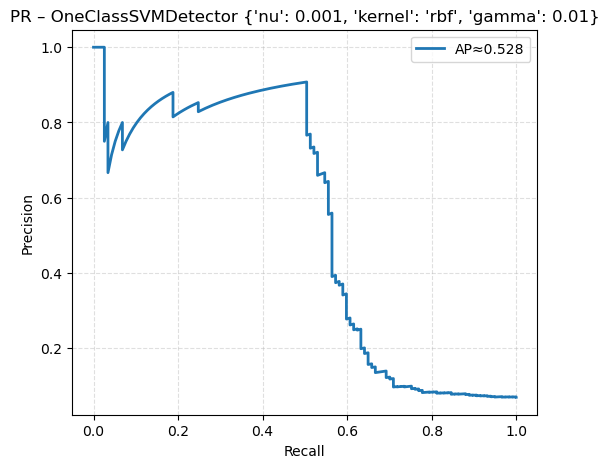

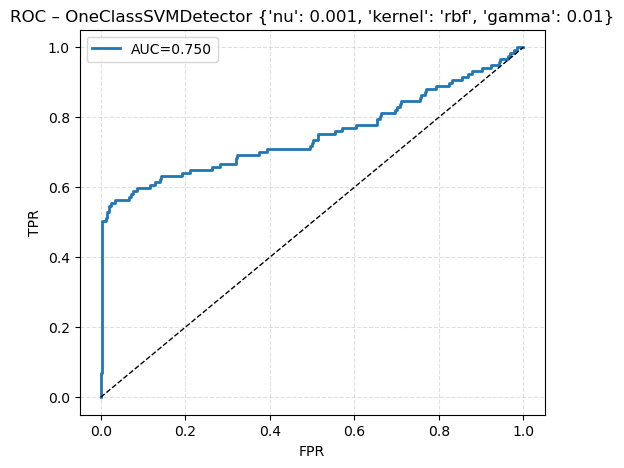

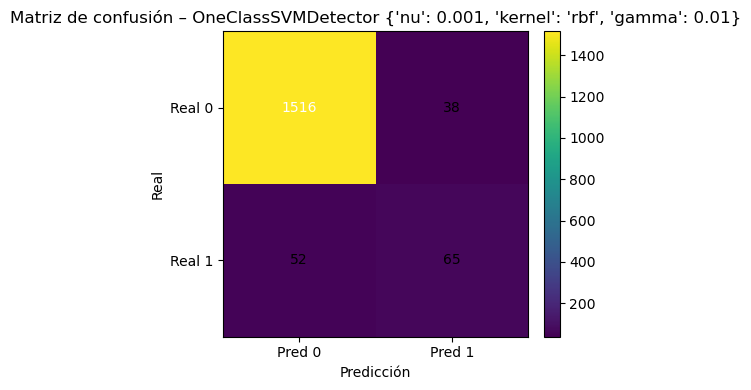

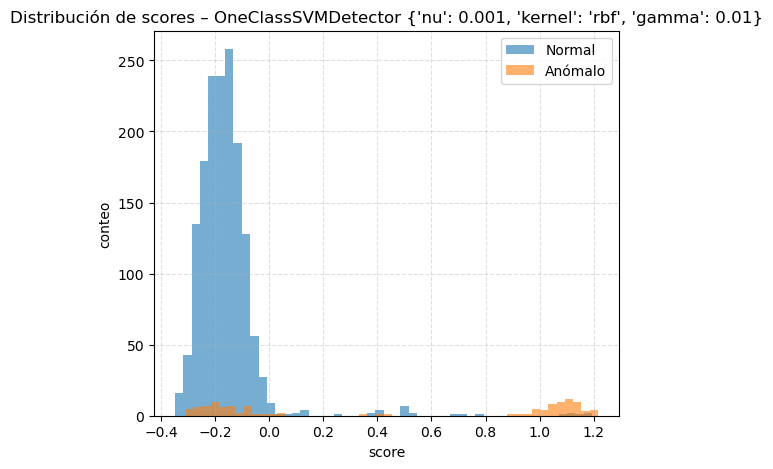

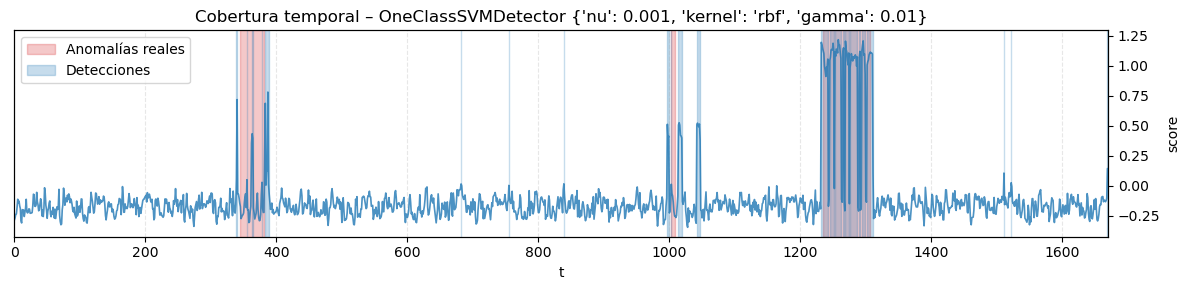

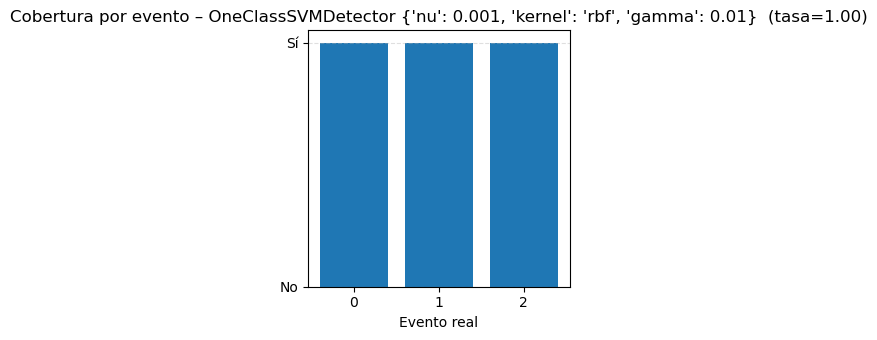

🏁 Ejecutando experimento en dataset: SKAB
[✓] DATA cargado desde /home/pablo/TFG/MDF-ANOMALY-DETECTION/modelos/data/SKAB/data.parquet (27563 filas)
   - Train: 9401 filas
   - Val:   10897 filas
   - Test:  7265 filas
Usando CPU (pandas + numpy) para este experimento.


Evaluación en test: 100%|██████████| 8/8 [00:00<00:00, 11.75it/s]

Top 8 configuraciones (ordenadas por nab en validación):


,precision,recall,f1,roc_auc,nab,window_coverage,nu,kernel,gamma
2,0.376,0.342,0.176,0.499,0.015,0.342,0.001,rbf,0.01
3,0.377,0.364,0.210,0.487,-0.439,0.364,0.001,rbf,0.1
0,0.331,0.374,0.220,0.478,-0.512,0.374,0.001,rbf,scale
1,0.331,0.374,0.220,0.478,-0.512,0.374,0.001,rbf,auto
8,0.358,0.377,0.230,0.482,-0.593,0.378,0.005,rbf,0.1
5,0.318,0.376,0.224,0.473,-0.603,0.377,0.005,rbf,scale
6,0.318,0.376,0.224,0.473,-0.603,0.377,0.005,rbf,auto
7,0.311,0.362,0.209,0.497,-0.616,0.362,0.005,rbf,0.01


Resultados finales en TEST (top-k configs):


,precision,recall,f1,roc_auc,nab,window_coverage,nu,kernel,gamma
0,0.429,0.001,0.002,0.569,0.474,0.001,0.001,rbf,0.01
1,0.447,0.045,0.081,0.565,0.049,0.043,0.001,rbf,0.1
2,0.422,0.061,0.106,0.568,-0.399,0.057,0.001,rbf,scale
3,0.422,0.061,0.106,0.568,-0.399,0.057,0.001,rbf,auto
4,0.432,0.058,0.102,0.564,-0.266,0.055,0.005,rbf,0.1
5,0.407,0.066,0.114,0.563,-0.619,0.063,0.005,rbf,scale
6,0.407,0.066,0.114,0.563,-0.619,0.063,0.005,rbf,auto
7,0.379,0.009,0.018,0.559,0.665,0.009,0.005,rbf,0.01


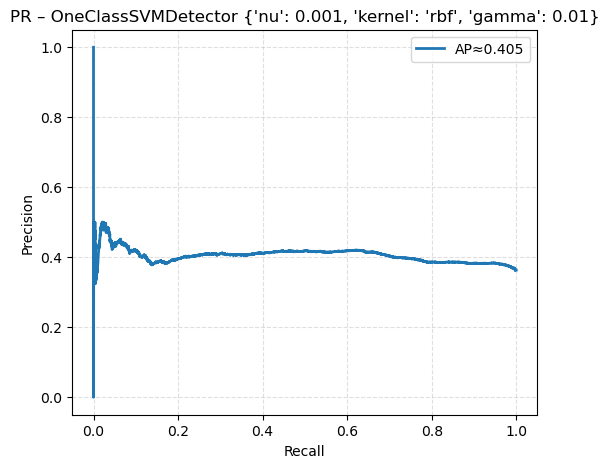

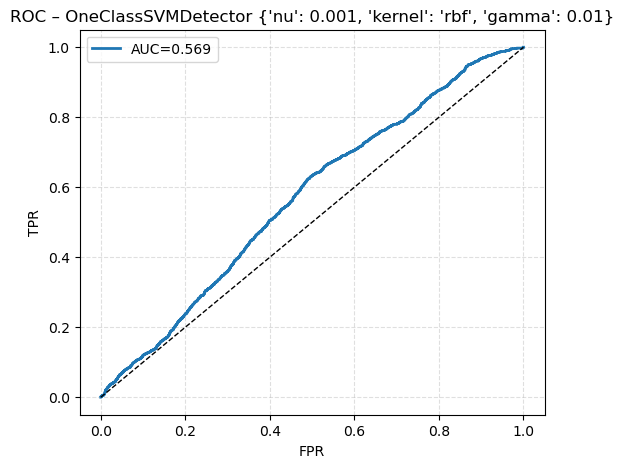

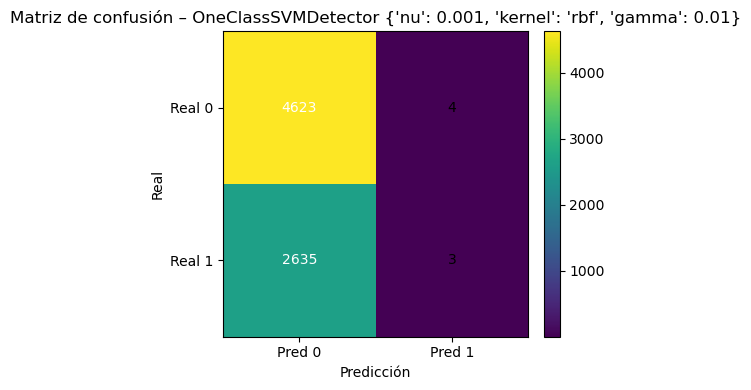

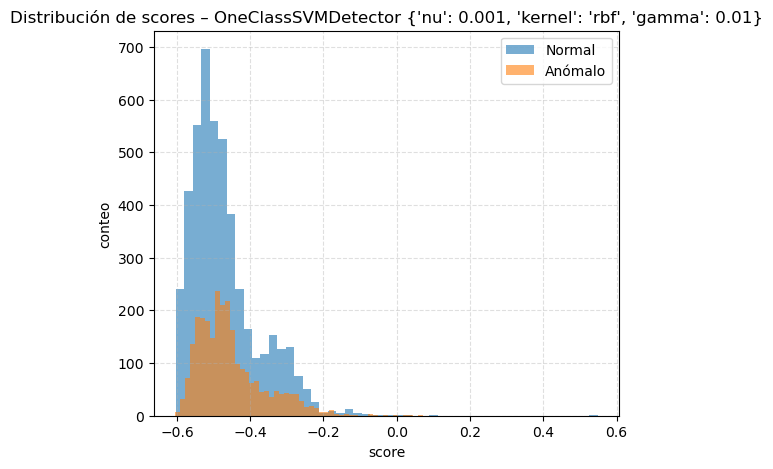

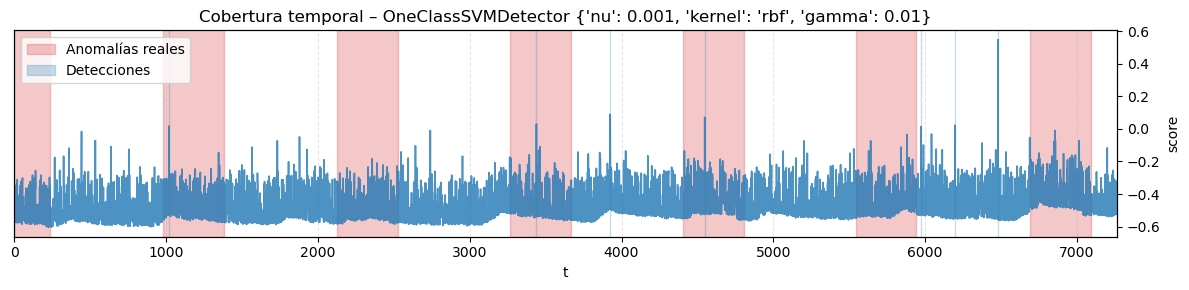

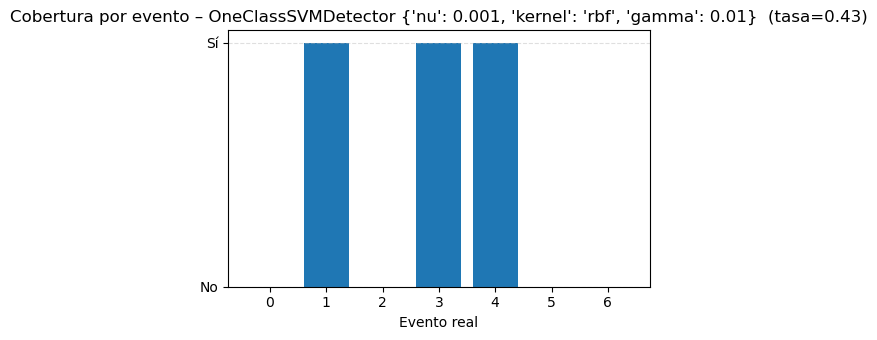

🏁 Ejecutando experimento en dataset: EbayRanSynCoders
[✓] DATA cargado desde /home/pablo/TFG/MDF-ANOMALY-DETECTION/modelos/data/EbayRanSynCoders/data.parquet (220322 filas)
   - Train: 132481 filas
   - Val:   52704 filas
   - Test:  35137 filas
Usando CPU (pandas + numpy) para este experimento.


/home/pablo/miniforge3/envs/anomaly-detection/lib/python3.11/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 36.74 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
Evaluación en test: 100%|██████████| 8/8 [01:45<00:00, 13.14s/it]

Top 8 configuraciones (ordenadas por nab en validación):


,precision,recall,f1,roc_auc,nab,window_coverage,nu,kernel,gamma
2,0.596,0.279,0.256,0.606,-0.098,0.360,0.001,rbf,0.01
7,0.528,0.305,0.279,0.618,-0.523,0.377,0.005,rbf,0.01
12,0.491,0.321,0.291,0.623,-0.547,0.400,0.010,rbf,0.01
0,0.420,0.338,0.295,0.631,-0.603,0.464,0.001,rbf,scale
1,0.420,0.338,0.295,0.631,-0.603,0.464,0.001,rbf,auto
5,0.412,0.362,0.316,0.632,-0.631,0.486,0.005,rbf,scale
6,0.412,0.362,0.316,0.632,-0.631,0.486,0.005,rbf,auto
11,0.409,0.385,0.335,0.637,-0.639,0.503,0.010,rbf,auto


Resultados finales en TEST (top-k configs):


,precision,recall,f1,roc_auc,nab,window_coverage,nu,kernel,gamma
0,0.579,0.474,0.521,0.762,-1.0,0.274,0.001,rbf,0.01
1,0.563,0.552,0.557,0.754,-1.0,0.449,0.005,rbf,0.01
2,0.543,0.582,0.562,0.747,-1.0,0.487,0.010,rbf,0.01
3,0.549,0.673,0.605,0.789,-1.0,0.475,0.001,rbf,scale
4,0.549,0.673,0.605,0.789,-1.0,0.475,0.001,rbf,auto
5,0.560,0.761,0.645,0.800,-1.0,0.553,0.005,rbf,scale
6,0.560,0.761,0.645,0.800,-1.0,0.553,0.005,rbf,auto
7,0.552,0.795,0.652,0.802,-1.0,0.575,0.010,rbf,auto


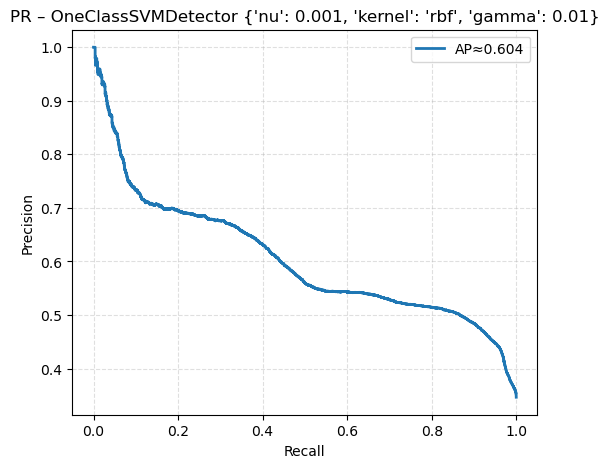

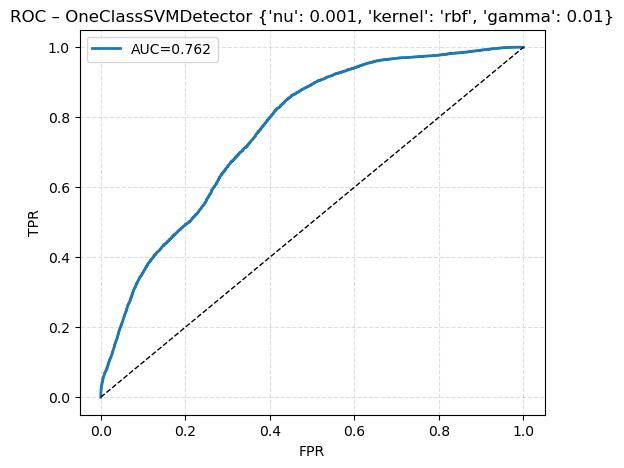

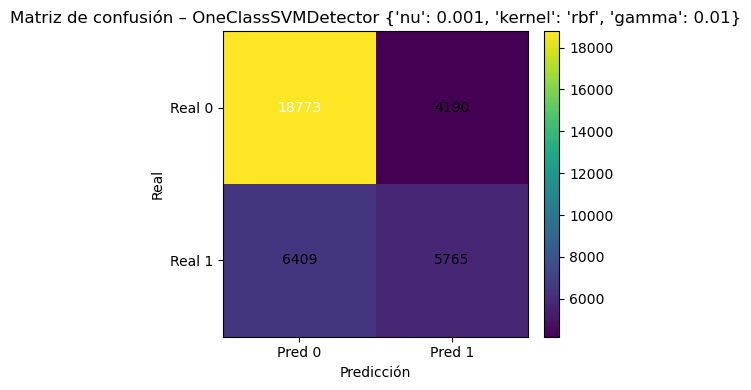

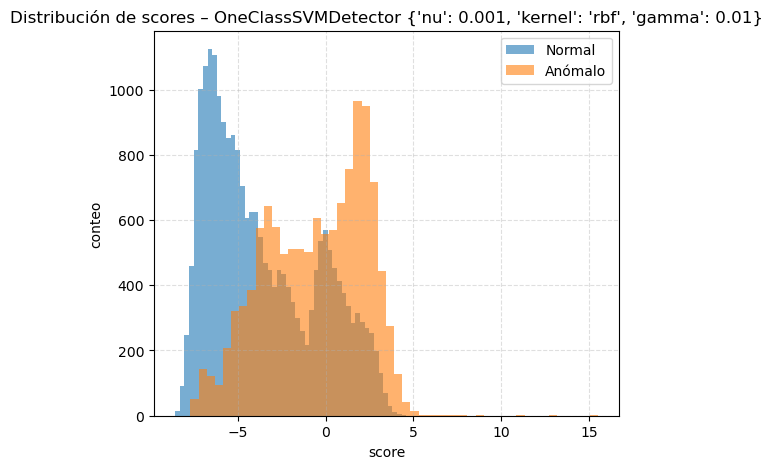

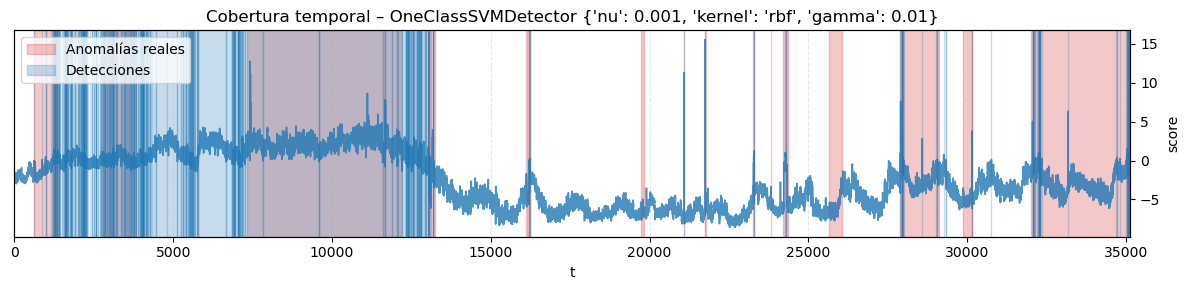

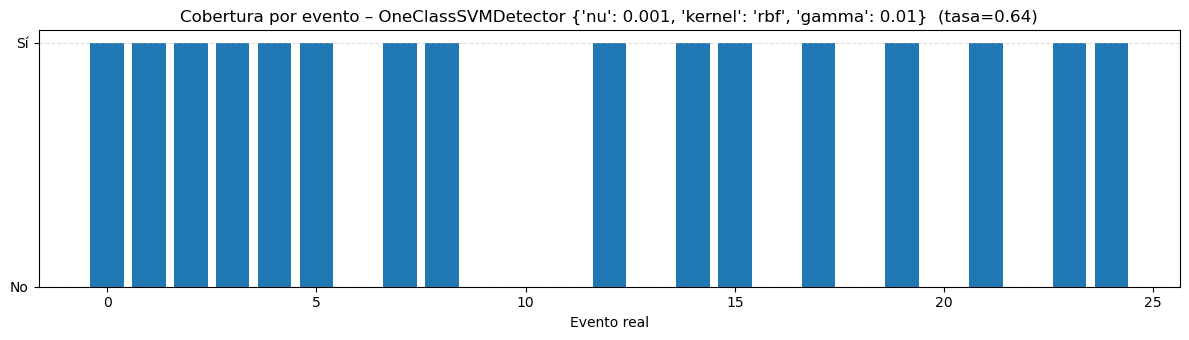

🏁 Ejecutando experimento en dataset: MSL
[✓] DATA cargado desde /home/pablo/TFG/MDF-ANOMALY-DETECTION/modelos/data/MSL/data.parquet (132046 filas)
   - Train: 58317 filas
   - Val:   44237 filas
   - Test:  29492 filas
Usando CPU (pandas + numpy) para este experimento.


/home/pablo/miniforge3/envs/anomaly-detection/lib/python3.11/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 22.31 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
Evaluación en test: 100%|██████████| 8/8 [09:10<00:00, 68.84s/it] 

Top 8 configuraciones (ordenadas por nab en validación):


,precision,recall,f1,roc_auc,nab,window_coverage,nu,kernel,gamma
2,0.223,0.066,0.073,0.401,-0.508,0.129,0.001,rbf,0.01
1,0.131,0.075,0.084,0.408,-0.667,0.135,0.001,rbf,auto
0,0.213,0.388,0.270,0.600,-1.000,0.336,0.001,rbf,scale
11,0.203,0.309,0.239,0.525,-1.000,0.268,0.010,rbf,auto
18,0.200,0.477,0.281,0.534,-1.000,0.387,0.050,rbf,0.1
17,0.185,0.432,0.258,0.526,-1.000,0.359,0.050,rbf,0.01
16,0.191,0.388,0.252,0.526,-1.000,0.320,0.050,rbf,auto
15,0.183,0.404,0.248,0.541,-1.000,0.353,0.050,rbf,scale


Resultados finales en TEST (top-k configs):


,precision,recall,f1,roc_auc,nab,window_coverage,nu,kernel,gamma
0,0.089,0.022,0.035,0.541,-0.432,0.015,0.001,rbf,0.01
1,0.058,0.025,0.035,0.436,-1.000,0.033,0.001,rbf,auto
2,0.026,0.021,0.023,0.539,-1.000,0.030,0.001,rbf,scale
3,0.061,0.063,0.062,0.414,-1.000,0.074,0.010,rbf,auto
4,0.115,0.062,0.081,0.542,-1.000,0.047,0.050,rbf,0.1
5,0.065,0.072,0.068,0.403,-1.000,0.060,0.050,rbf,0.01
6,0.059,0.074,0.066,0.395,-1.000,0.080,0.050,rbf,auto
7,0.065,0.077,0.070,0.401,-1.000,0.096,0.050,rbf,scale


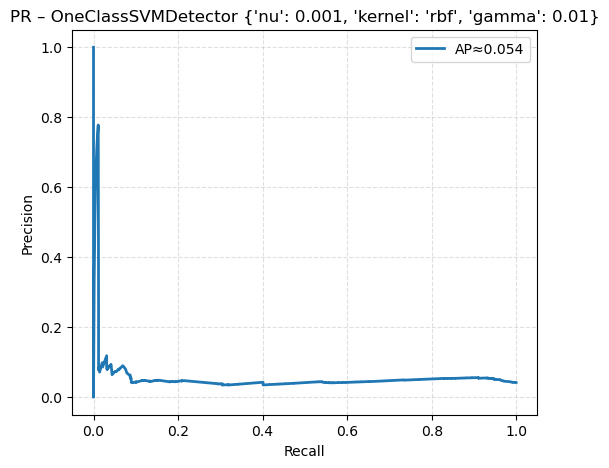

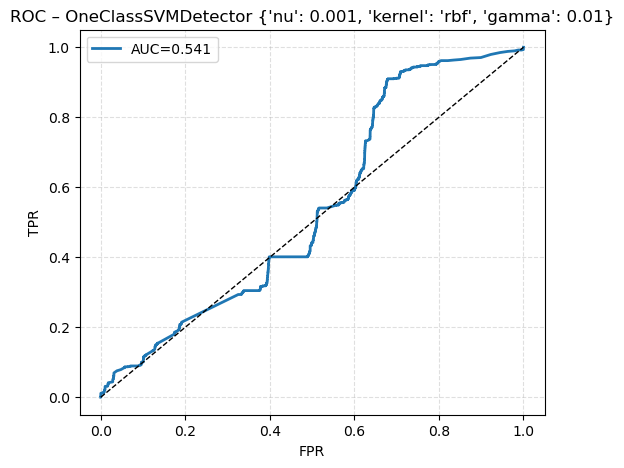

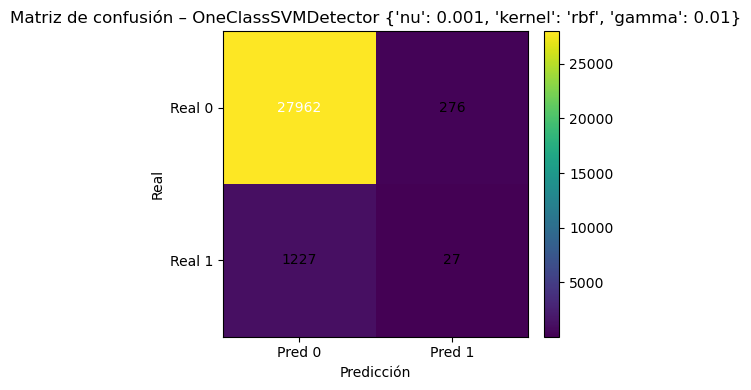

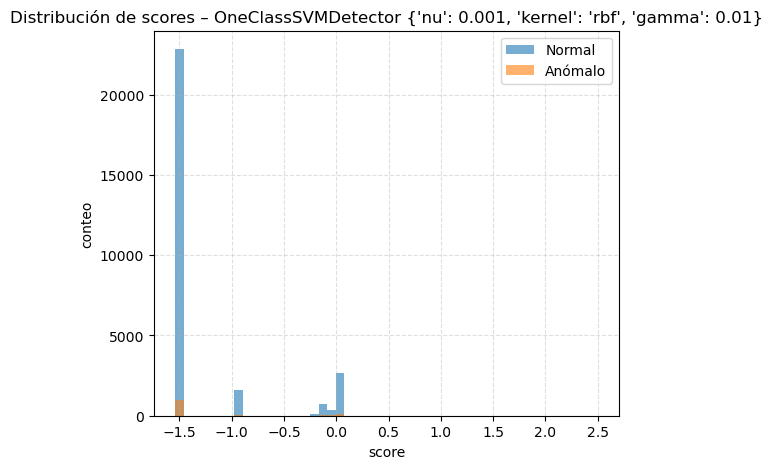

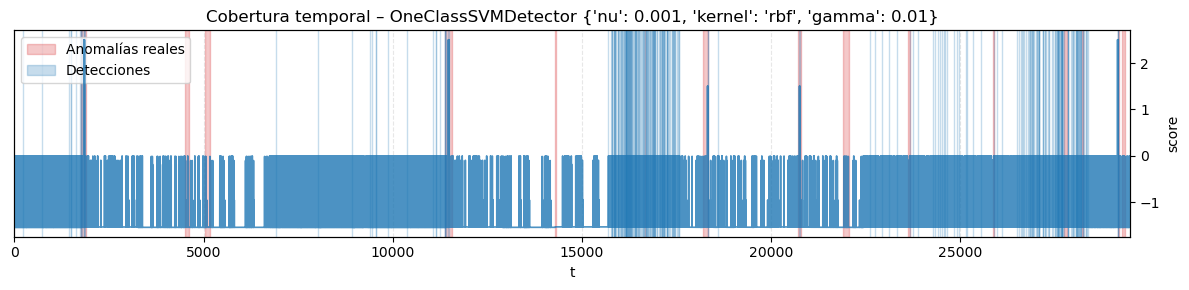

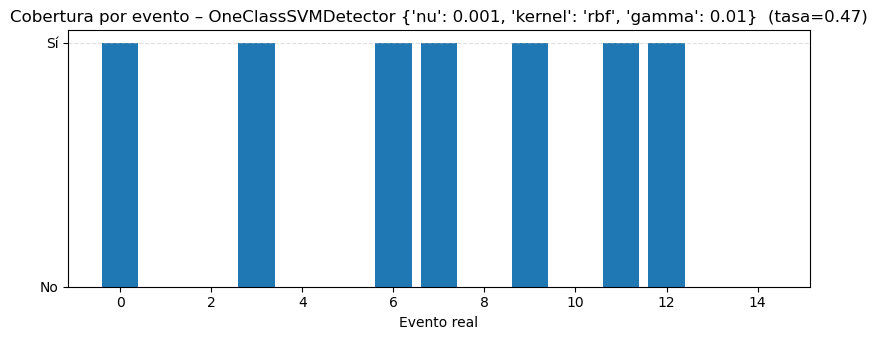

🏁 Ejecutando experimento en dataset: SMAP
[✓] DATA cargado desde /home/pablo/TFG/MDF-ANOMALY-DETECTION/modelos/data/SMAP/data.parquet (562800 filas)
   - Train: 135183 filas
   - Val:   256570 filas
   - Test:  171047 filas
Usando CPU (pandas + numpy) para este experimento.


/home/pablo/miniforge3/envs/anomaly-detection/lib/python3.11/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 40.36 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
Evaluación en test: 100%|██████████| 8/8 [2:08:38<00:00, 964.82s/it]   

Top 8 configuraciones (ordenadas por nab en validación):


,precision,recall,f1,roc_auc,nab,window_coverage,nu,kernel,gamma
0,0.154,0.145,0.149,0.307,-1.0,0.182,0.001,rbf,scale
1,0.070,0.159,0.092,0.355,-1.0,0.237,0.001,rbf,auto
18,0.073,0.214,0.107,0.392,-1.0,0.427,0.050,rbf,0.1
17,0.073,0.214,0.107,0.355,-1.0,0.427,0.050,rbf,0.01
16,0.070,0.159,0.092,0.392,-1.0,0.237,0.050,rbf,auto
15,0.130,0.095,0.106,0.315,-1.0,0.188,0.050,rbf,scale
14,0.104,0.098,0.084,0.287,-1.0,0.196,0.010,rbf,1.0
13,0.073,0.214,0.107,0.355,-1.0,0.427,0.010,rbf,0.1


Resultados finales en TEST (top-k configs):


,precision,recall,f1,roc_auc,nab,window_coverage,nu,kernel,gamma
0,0.022,0.078,0.034,0.419,-1.0,0.326,0.001,rbf,scale
1,0.022,0.078,0.034,0.419,-1.0,0.326,0.001,rbf,auto
2,0.015,0.037,0.022,0.408,-1.0,0.194,0.050,rbf,0.1
3,0.015,0.039,0.022,0.407,-1.0,0.195,0.050,rbf,0.01
4,0.022,0.086,0.035,0.407,-1.0,0.352,0.050,rbf,auto
5,0.016,0.038,0.022,0.407,-1.0,0.200,0.050,rbf,scale
6,0.036,0.055,0.043,0.358,-1.0,0.165,0.010,rbf,1.0
7,0.022,0.079,0.034,0.417,-1.0,0.326,0.010,rbf,0.1


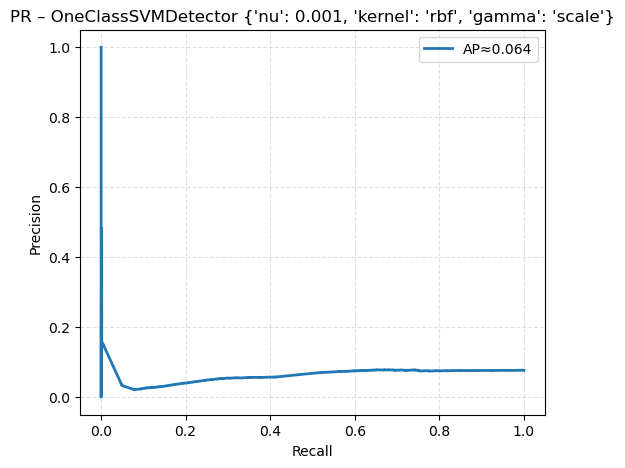

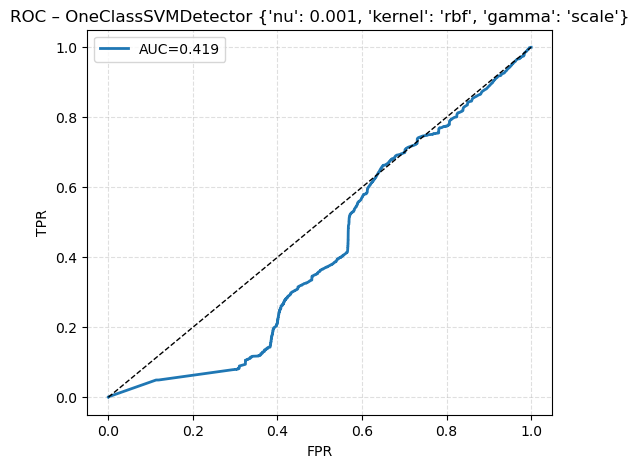

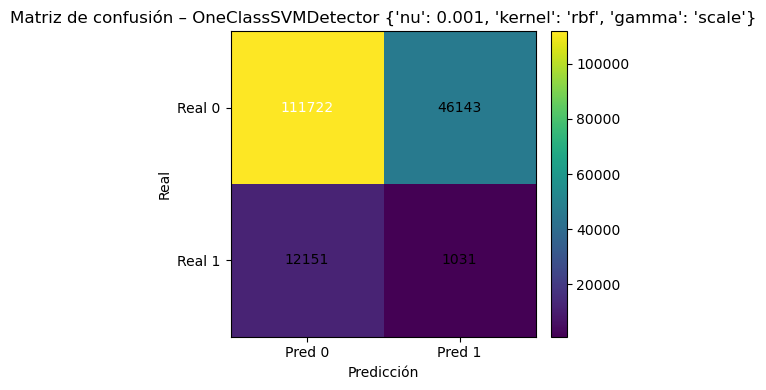

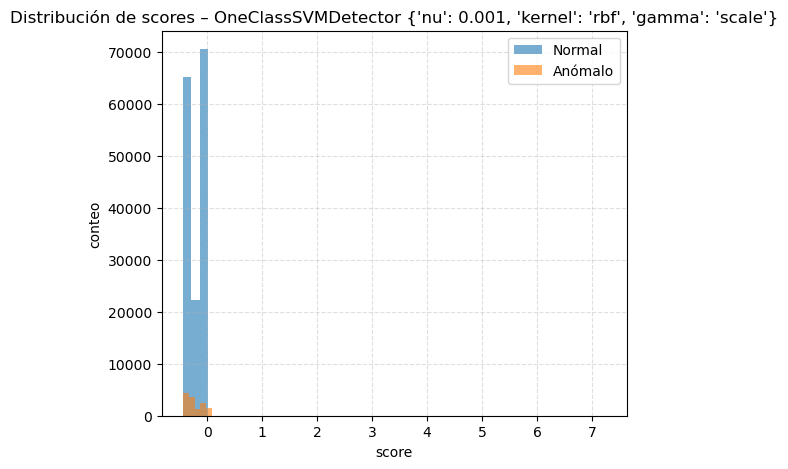

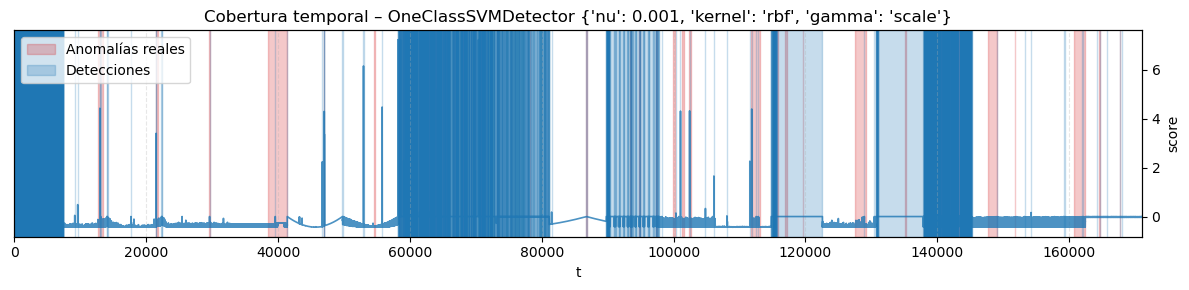

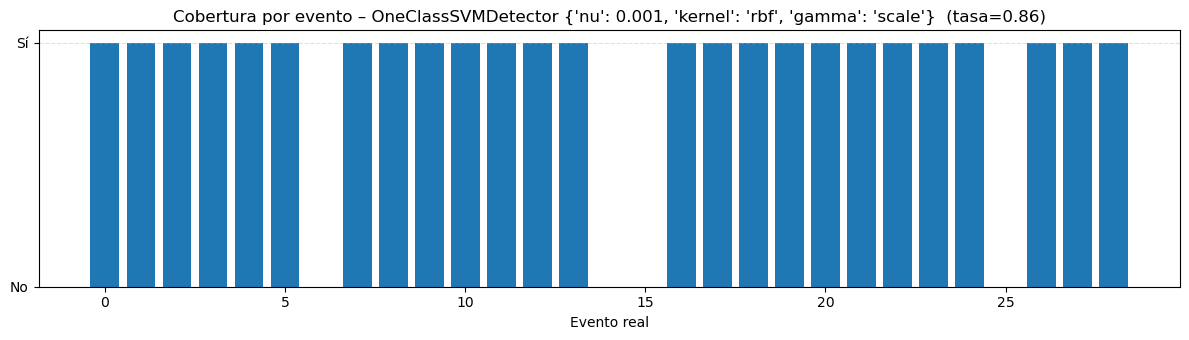

Cliente cerrado
Cluster cerrado


In [5]:
# === Experimentos OCSVM: datasets pequeños/medianos ===
from runner import run_dataset_experiment
from modelos.OneClassSVMDetector import OneClassSVMDetector

# Grid manejable y efectivo
param_grid = {
    "nu": [0.001, 0.005, 0.01, 0.05],
    "kernel": ["rbf"],
    "gamma": ["scale", "auto", 0.01, 0.1, 1.0],
}

# Datasets no masivos
datasets = ["BATADAL", "SKAB", "EbayRanSynCoders", "MSL", "SMAP"]

# Arranca cluster CPU (usando tu helper definido antes en el notebook)
start_cluster(use_gpu=False)

for dataset in datasets:
    df_results, topk, df_final = run_dataset_experiment(
        dataset_name=dataset,
        model_class=OneClassSVMDetector,
        param_grid=param_grid,
        metrics=metrics,
        params_cv={"num_windows": 3},     # 3 splits para acelerar
        device="cpu",
        mode="tscv",                      # validación temporal
        hampel_cfg={"window": 100, "sigma": 5.0},
        top_k=8,
        sort_metric="nab",
        plot_mode="best"
    )

stop_cluster()

### Experimento para dataset grande

In [ ]:
import warnings
warnings.filterwarnings("ignore", message="Cannot get CPU affinity")

from dask.distributed import Client, LocalCluster
from runner import run_dataset_experiment
from modelos.OneClassSVMDetector import OneClassSVMDetector

# Levanta un cluster CPU más conservador en memoria:
# - menos workers
# - 1 hilo por worker
# - límite de memoria por worker (ajusta si tienes más RAM)
wadi_cluster = LocalCluster(
    n_workers=3,
    threads_per_worker=2,
    memory_limit="8GB"
)
wadi_client = Client(wadi_cluster)
print(wadi_client)

# Grid reducido para WADI (evitar explosión de coste)
param_grid_wadi = {
    "nu": [0.005, 0.01, 0.02],
    "kernel": ["rbf"],
    "gamma": ["scale", 0.01, 0.1],   # evita valores muy grandes que sobreajustan
}

df_results, topk, df_final = run_dataset_experiment(
    dataset_name="WADI",
    model_class=OneClassSVMDetector,
    param_grid=param_grid_wadi,
    metrics=metrics,
    params_cv={"num_windows": 3},
    device="cpu",
    mode="tscv",
    hampel_cfg={"window": 200, "sigma": 5.0},  # ventana algo mayor por ruido/longitud
    top_k=8,
    sort_metric="nab",
    plot_mode="best"
)

# Cierra cluster específico de WADI
wadi_client.close()
wadi_cluster.close()


## 4. Experimentos con Autoencoders

Los **Autoencoders** son redes neuronales entrenadas para reconstruir los datos de entrada.  
En detección de anomalías se aprovecha que el modelo **aprende a reconstruir bien los patrones normales**, 
mientras que los ejemplos anómalos producen un **error de reconstrucción elevado**.  

En este proyecto se ha implementado una única versión en **GPU**, dado que el entrenamiento 
de redes neuronales resulta mucho más eficiente en CUDA.  

Los hiperparámetros principales que se exploran son:

- `latent_dim`: tamaño del espacio latente.  
- `lr`: tasa de aprendizaje.  
- `epochs`: número de épocas de entrenamiento.  
- `batch_size`: tamaño de los lotes en entrenamiento.  


### Experimentos para el cojunto de datasets

In [ ]:
# === Experimentos con Autoencoder en GPU ===
import warnings
warnings.filterwarnings("ignore", message="Cannot get CPU affinity")

from runner import run_dataset_experiment
from modelos.AutoencoderDetector import AutoencoderDetector

# Grid de hiperparámetros
param_grid = {          
    "latent_dim": [8, 16],
    "lr": [1e-3, 5e-4],
    "epochs": [80],
    "batch_size": [128, 256]
}

# Datasets medianos/grandes (GPU obligatoria)
datasets = ["BATADAL", "SKAB", "EbayRanSynCoders", "MSL", "SMAP", "WADI"]

# Arranca cluster GPU
start_cluster(use_gpu=True)

for dataset in datasets:
    print(f"\n=== Autoencoder @ {dataset} ===")
    df_results, topk, df_final = run_dataset_experiment(
        dataset_name=dataset,
        model_class=AutoencoderDetector,
        param_grid=param_grid,
        metrics=metrics,
        params_cv={"num_windows": 3},    # validación con 3 splits
        device="gpu",
        mode="walkforward",              # validación expansiva
        hampel_cfg={"window": 100, "sigma": 5.0},
        top_k=5,
        sort_metric="nab",
        plot_mode="best"
    )

stop_cluster()


## 5. Experimentos con Transformers Autoencoders

Los **Transformers Autoencoders** combinan la capacidad de los *Transformers* para capturar 
dependencias de largo alcance con la filosofía de los **Autoencoders**.  
El modelo se entrena para **reconstruir secuencias normales** y detectar anomalías 
cuando el error de reconstrucción aumenta en presencia de patrones anómalos.  

En este proyecto se ha implementado únicamente una versión en **GPU**, 
dado que el mecanismo de atención y el entrenamiento con secuencias largas 
son altamente costosos en CPU.  

Los hiperparámetros principales que se exploran incluyen:

- `seq_len`: longitud de la ventana temporal.  
- `latent_dim`: tamaño del espacio latente.  
- `lr`: tasa de aprendizaje.  
- `epochs`: número de épocas.  
- `batch_size`: tamaño de los lotes de entrenamiento.  


In [ ]:
import warnings
warnings.filterwarnings("ignore", message="Cannot get CPU affinity")

from runner import run_dataset_experiment
from modelos.TransformerAutoencoderDetector import TransformerAutoencoderDetector

# Grid de hiperparámetros inicial
param_grid = {          
    "seq_len": [10],   # Decido usar solo windowing de tamaño 10
    "latent_dim": [16, 32],
    "lr": [1e-4, 5e-4],
    "epochs": [80],
    "batch_size": [256, 512],
}

# Datasets grandes donde los Transformers son más útiles
datasets = ["BATADAL", "SKAB", "EbayRanSynCoders", "MSL", "SMAP", "WADI"]

# Arranca cluster GPU
start_cluster(use_gpu=True)

for dataset in datasets:
    df_results, topk, df_final = run_dataset_experiment(
        dataset_name=dataset,
        model_class=TransformerAutoencoderDetector,
        param_grid=param_grid,
        metrics=metrics,
        params_cv={"num_windows": 3},    # validación con 3 splits
        device="gpu",
        mode="walkforward",              # validación expansiva
        hampel_cfg={"window": 100, "sigma": 5.0},
        top_k=5,
        sort_metric="nab",
        plot_mode="best"
    )

stop_cluster()


## Conclusión del Capítulo de Experimentos

En este capítulo se han mostrado ejemplos prácticos de ejecución de experimentos con 
los distintos modelos de detección de anomalías desarrollados:

- **PCA (CPU/GPU)**  
- **Isolation Forest (CPU/GPU)**  
- **One-Class SVM (CPU)**  
- **Autoencoders (GPU)**  
- **Transformers Autoencoders (GPU)**  

Todos los modelos se han probado siguiendo un flujo común:  
levantamiento del cluster Dask, definición de métricas, configuración de grids de 
hiperparámetros y ejecución con `run_dataset_experiment`.

El objetivo principal de este capítulo no era analizar los resultados en detalle, 
sino documentar cómo se han diseñado y ejecutado los experimentos de manera reproducible.  

El análisis comparativo de los resultados, la discusión de métricas y la selección del mejor modelo 
se presentan en la **memoria del TFG**, donde se abordan con mayor profundidad.
